In [103]:
import os
import warnings
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency, kruskal, pearsonr, shapiro, levene, mannwhitneyu, spearmanr
from termcolor import colored

warnings.filterwarnings("ignore")

In [5]:
firstpath = os.getcwd().split("\\")[:-1]
path = "//".join(firstpath)+"//dataset"
train = pd.read_csv(path+"//train.csv")
df = train.copy()

# Binary Classification With A Bank
#### Kaggle Competition : https://www.kaggle.com/competitions/playground-series-s5e8

# Plan Notebook EDA :
## 1. Connaissance des données

- features :
	- numériques (continues/discretes)
	- qualitatives (ordinale/ nominale) 
		= > traitement : continue Vs discrètes & qualitatives
- Présence target ? 
	1. oui = supervisée
		=> continue, régression
		=> discrètes/qualitatives : classification (binaire, multiclasse)
		=> multi target ? (rare)
		
	2. non = non supervisée
		- on cherchera des similitude entre les features pour créer la target
		-  utilisation de modèle non supervisé :
			- réduction dimension : PCA, tSNE, ISOMAP, ..
			- clusterisation : KMeans, DBSCAN, CAH, ..
            
- Imputation : Données manquantes ? 
	- oui : 
		- si % NaN trop important => suppression de la colonne
		- Vrai NaN ou absence d'élément ? 
			- ex : presence de NaN dans colonne numériques, mais pas de valeur 0. Peut-être que NaN = 0 ?
		- NaN peut être un renseignement
			- ex2 : colonne ticket contenant NaN, le NaN = l'individu n'a pas de ticket (fraudeur ?)
		- Donc vérifier la signification du NaN
		- Si faible % NaN (<5%) de type MCAR : supprimer les lignes en contenant 
		- Entre 5 et 40 % : faire de l'imputation en fonction du type MNAR/MAR
			- Variable continue 
				- imputer par moyenne ou médiane si présence outliers trop important (vérifier via boxplot, calcul du skew : > 0.5 = **asymétrique; donc médiane**)
				- imputer par régression linéaire (si correlation avec d'autres features; x1 ~ x2 + x3 où x1 contient les NaN)
			- Variables qualitatives ordinale + quantitative discrètes :
				- imputation par la médiane
				- imputer par la valeur suivante/précédente (quand il y a notion "d'ordre")
			- Variables qualitatives nominale + catégorielle :
				- Remplacer par le mode

	
## 2. DataVisualisation :
- Analyses des features
	- Analyse univariée pour comprendre chaque feature indépendamment les unes des autres
  	- Analyse bivariée : relation entre 2 features

## 3. Tests statistiques : 
- En complément de la datavisualisation afin de vérifier la relation entre 2 variables (généralement target/feature) Nous regarderons, en fonction de nos données, lequel des cas suivant nous allons avoir à faire :
	- Cas 1 : 2 features continues 
		- Loi de Pearson si les données suivent une loi normale (heatmap) : si -1 anticorrélée, 1 corrélée, 0 alors p-e une relation non linéaire
		- Loi Spearman/Kendall  : si les 2 ou 1 des 2 features ne suivent pas une loi normale : si -1/1 alors forte (anti)corrélation, 0 & pval élevée : pas relation
	- Cas 2 : 2 features discrètes/qualitatives
		- test du Chi2
	- Cas 3 : 1 feature de chaque type
		- On regarde si la feature continue suit une loi normale et si la feature discrètes a 2 ou >2 modalités
			- 2 modalités : 
				- loi normale + égalité variance : test Student
				- loi normale + non égalité variance : test Welch
				- loi non normale : test Man Whitney
			- plus de 2 modalités :
				- loi normale : ANOVA
				- loi non normale : Kruskal Wallis
			
	- Vérifier si la feature suit une loi normale : Shapiro Wilk
		- Pour vérifier la dépendance, on pose H0 : variables indépendantes. Si pval<risque seuil (alpha), on rejette H0 pour la réciproque H1 avec un risque inférieur au seuil posé.
	On conclue à la dépendance des variables
 à la dépendance des variables
	

# 1. Connaissance des données :

In [6]:
print("Dim : ", df.shape)
df.head()

Dim :  (750000, 18)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [7]:
df.default.unique()

array(['no', 'yes'], dtype=object)

In [8]:
df.dtypes.value_counts()

int64     9
object    9
Name: count, dtype: int64

In [9]:
df.shape[0] == df.id.nunique()

True

In [10]:
df.y.value_counts(normalize=True)*100

y
0    87.934933
1    12.065067
Name: proportion, dtype: float64

- 17 features (dont id) et 1 target binaire [0,1] : **classification**
- pas de doublons
- 9 variables qualitatives, 9 numériques

### Objectif : 
- Ensemble des données de prédiction de souscription pour un dépôt bancaire
- Les données ont été obtenues à partir d'une campagne de marketing, chaque observation correspond à un client

#### Signification des features : 
 - age : age
 - job : métier
 - marital : statut marital
 - education : niveau d'étude
 - default : si défaut de crédit 
 - balance : solde annuel moyen en euro
 - housing : a t il un prêt immobilier ?
 - loan : a t il un prêt personnel ?
 - contact : type de contact de communication
 - day : dernier jour de contact du mois
 - month : mois du dernier contact de l'année
 - duration : durée du dernier contact (en seconde)
 - campaign : nombre de contact effectuée au cours de cette campagne
 - pdays : nombre de jour depuis que le client a été contact pour la dernière fois lors d'une campagne précédente (**-1** pour un client non contacté auparavant)
 - previous : nombre de contact effectuée avant cette campagne
 - poutcome : résultat de la campagne marketing précédente
 - y : **target**, indique si le client à fait un placement de fond

#### Imputation de données : 
- Regardons s'il y a des données manquantes :

In [11]:
df.isnull().mean()[df.isnull().any(axis=0)]

Series([], dtype: float64)

Pas de données manquantes

## 2. DataVisualization :

### 2.1 Analyse Univariée
#### Features numériques :

In [12]:
var_num = df.select_dtypes(exclude="object").drop("id",axis=1).columns.tolist()
var_qual = df.select_dtypes("object").columns.tolist()
target = [df.y.name]

In [13]:
df[var_num].nunique().sort_values()

y              2
day           31
previous      50
campaign      52
age           78
pdays        596
duration    1760
balance     8217
dtype: int64

Considérons les variables jusqu'à "campaign" comme discrète, à partir de âge comme continue

In [14]:
var_cont, var_dis = [], []
for i in var_num:
    if df[i].nunique() <= df.campaign.nunique():
        var_dis.append(i)
    else:
        var_cont.append(i)

### Visualisation des variables discrètes 

In [15]:
var_dis

['day', 'campaign', 'previous', 'y']

#### campaign :

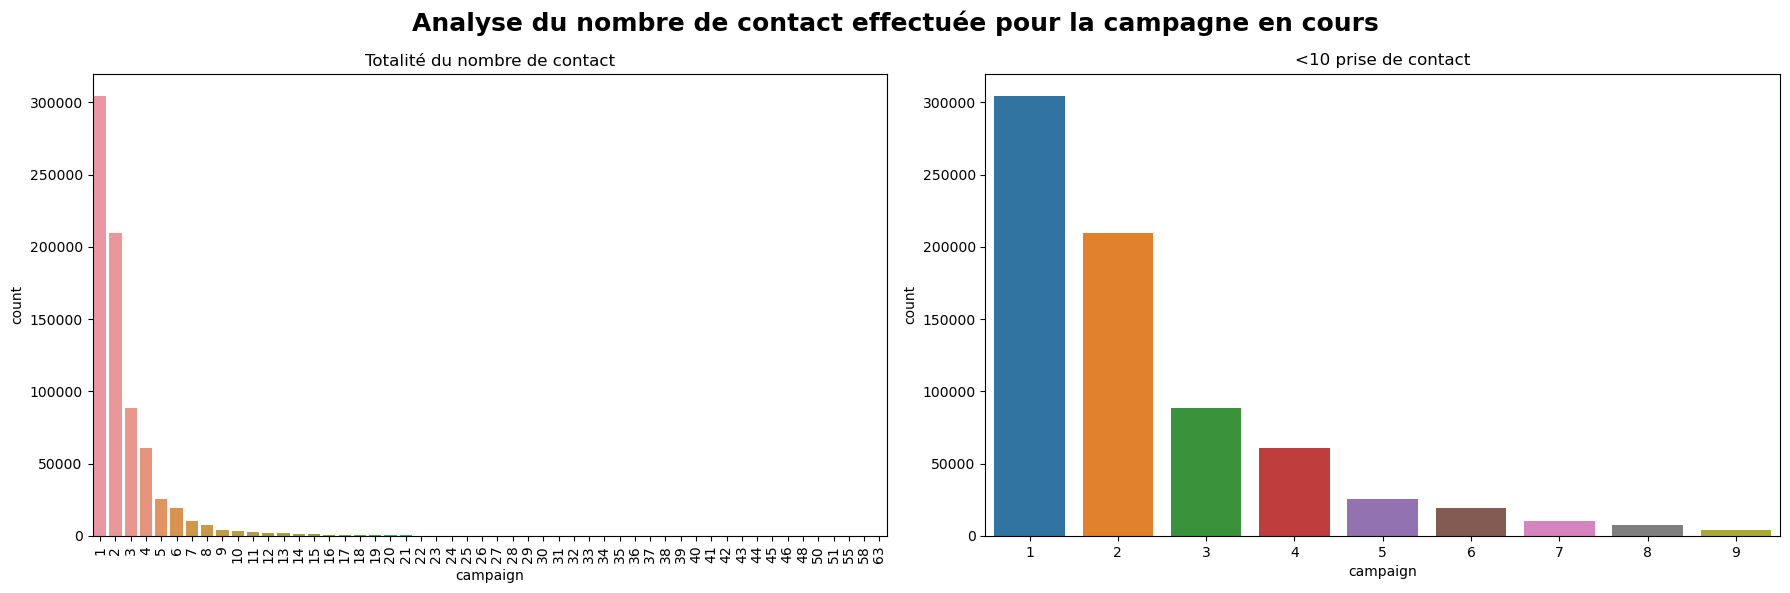

In [16]:
fig,axes = plt.subplots(1,2,figsize=(18,6))
#fig1
ax = sns.countplot(data = df, x = "campaign", ax=axes[0])
lab = ax.get_xticklabels()#labels
ax.set_title("Totalité du nombre de contact")

ax.set_xticklabels(labels=lab, rotation = 90)
#Fig2
ax2 = sns.countplot(data = df[df.campaign<10], x = "campaign", ax=axes[1])
ax2.set_title("<10 prise de contact")
fig.suptitle("Analyse du nombre de contact effectuée pour la campagne en cours", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
print("Dénombrement du nombre de client ayant eu au moins 10 prises de contact :")
pd.DataFrame(df.campaign[df.campaign>10].value_counts()).T

Dénombrement du nombre de client ayant eu au moins 10 prises de contact :


campaign,11,12,13,14,15,16,17,18,19,20,...,44,46,39,51,45,42,48,55,63,58
count,2576,2027,1720,1231,1099,1018,902,678,556,530,...,10,8,8,7,4,3,2,1,1,1


#### Observation : 
- On comptabilise un nombre de campagne allant  de 1 jusqu'à 63. 
- La majorité des contacts effectuée s'ajencent autour de 1 à 4. 
- A partir de 5 prises de contact, c'est plus rare
- On peut noter qu'on quelques rare client avec plus de 50 prises de contact, ce qui paraît anormalement élevé

#### previous :

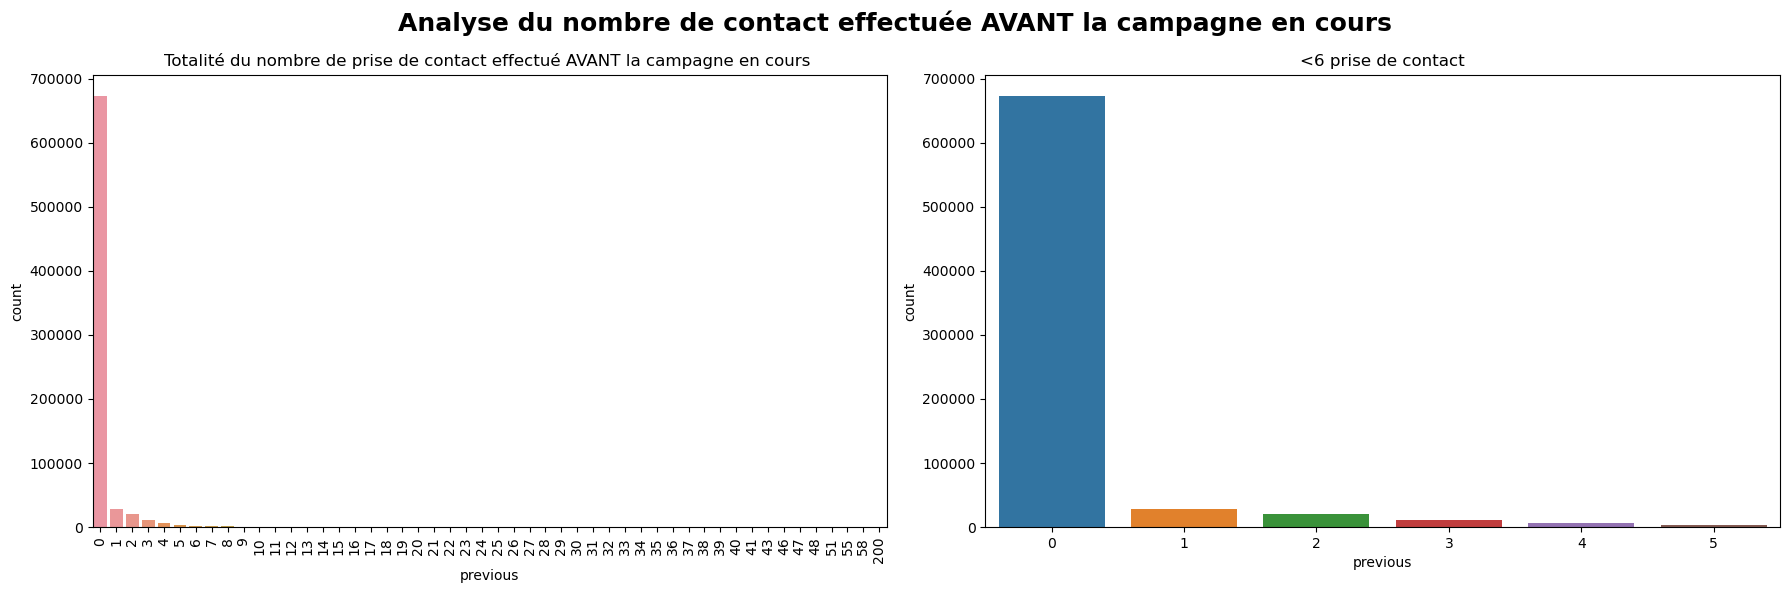

In [18]:
fig,axes = plt.subplots(1,2,figsize=(18,6))
#fig1
ax = sns.countplot(data = df, x = "previous", ax=axes[0])
lab = ax.get_xticklabels()#labels
ax.set_title("Totalité du nombre de prise de contact effectué AVANT la campagne en cours ")

ax.set_xticklabels(labels=lab, rotation = 90)
#Fig2
ax2 = sns.countplot(data = df[df.previous<6], x = "previous", ax=axes[1])
ax2.set_title("<6 prise de contact")

fig.suptitle("Analyse du nombre de contact effectuée AVANT la campagne en cours", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
print("% des valeurs de prise de contact")
(df.previous.value_counts(normalize=True)*100).loc[lambda x:x>1]

% des valeurs de prise de contact


previous
0    89.657467
1     3.778933
2     2.729067
3     1.376800
Name: proportion, dtype: float64

In [20]:
print("Dénombrement du nombre de client ayant eu au moins 5 prises de contact :")
pd.DataFrame(df.previous[df.previous>4].value_counts().sort_index()).T

Dénombrement du nombre de client ayant eu au moins 5 prises de contact :


previous,5,6,7,8,9,10,11,12,13,14,...,40,41,43,46,47,48,51,55,58,200
count,3882,2183,1730,1036,697,501,503,320,327,137,...,1,4,4,1,1,1,4,2,1,1


In [21]:
df[df.previous == 200]

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
537358,537358,27,technician,single,tertiary,no,0,no,no,cellular,17,sep,7,1,100,200,other,0


In [22]:
df.loc[df["id"] == 537358]

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
537358,537358,27,technician,single,tertiary,no,0,no,no,cellular,17,sep,7,1,100,200,other,0


In [23]:
#Suppression de la ligne par exclusion :
df = df[~(df["previous"]==200)]

#### Observation : 
- On comptabilise un nombre de campagne allant  de 1 jusqu'à 200 !
- La valeur 200 semble être une erreur, nous allons **supprimer** cette observation
- **90% des individus** n'ont pas eu de prise de contact avant la campagne

#### day :

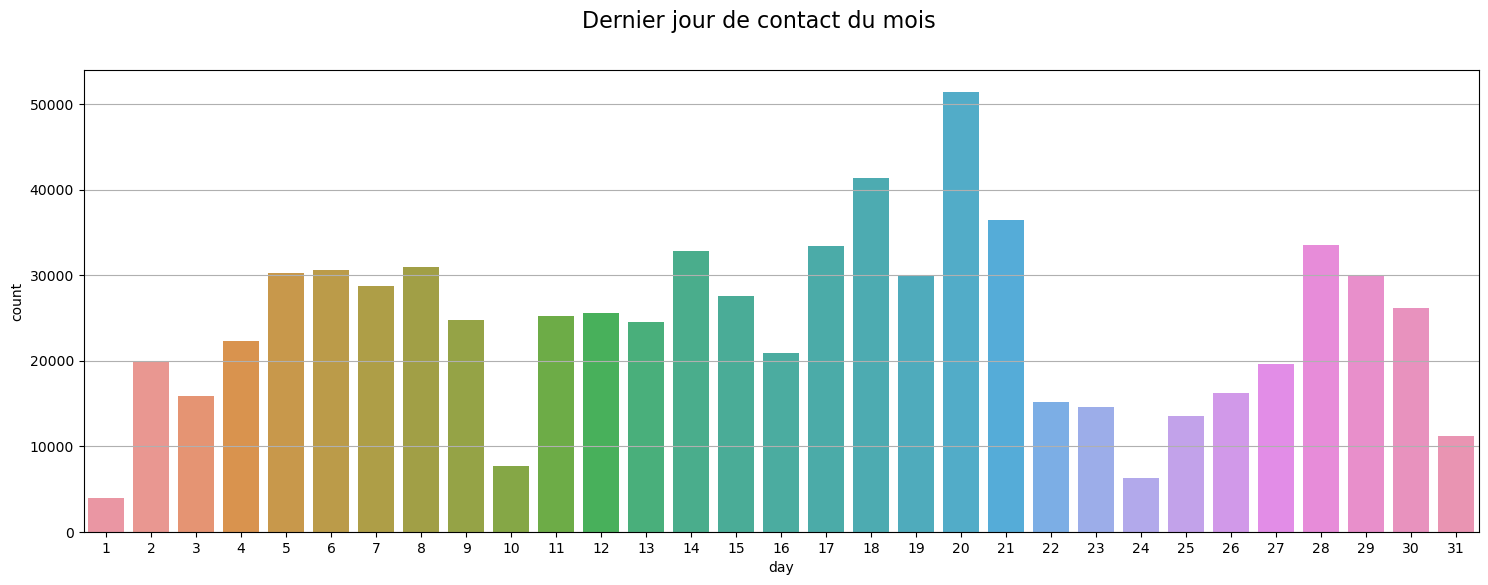

In [24]:
plt.figure(figsize=(18,6))
plt.grid()
sns.countplot(data = df, x = "day")
plt.suptitle("Dernier jour de contact du mois", fontsize = 16)
plt.show()

#### Observation :
- Les données sont assez éparses. On constate que c'est souvent le 20ème jour qui est le plus fréquent.
- Les jours 1, 10 et 24 sont les plus rarement utilisé pour la prise de contact

### Visualisation de la target :
#### y :


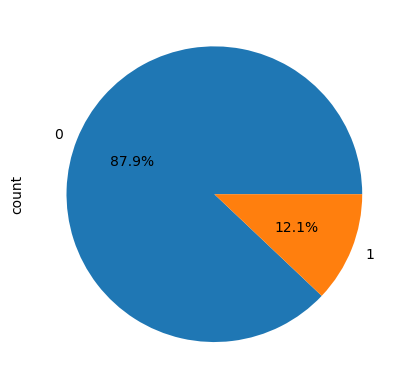

In [25]:
df.y.value_counts().plot.pie(labels =df["y"].unique(),
                             autopct='%1.1f%%')
plt.show()

- Les proportions de classe sont **déséquilibrées** : ~ 90/10
    - Dans la partie modélisation il faudra en tenir compte et adapter une stratégie, par exemple : utilisation de stratify dans le train_test_split, SMOTE, class_weight, etc.

### Visualisation des variables continues
- On les considères comme continue car elles prennent un nombre de modalité élevée, cependant ici dans le jeu de données, elles sont en **int** (ce qui s'apparente souvent à une variable discrète)

In [26]:
df[var_cont].agg(["min","max"])
#on a des valeurs négatives

,age,balance,duration,pdays
min,18,-8019,1,-1
max,95,99717,4918,871


#### Observation : 
- On a des valeurs négatives, comme pour balance, avec une forte dispertion des valeurs (de l'ordre de -8000 à 100.000)
- pdays = -1 c'est pour les clients jamais contacté auparavant, donc on va séparé cette valeur du reste pour analyser cette feature

#### age : 

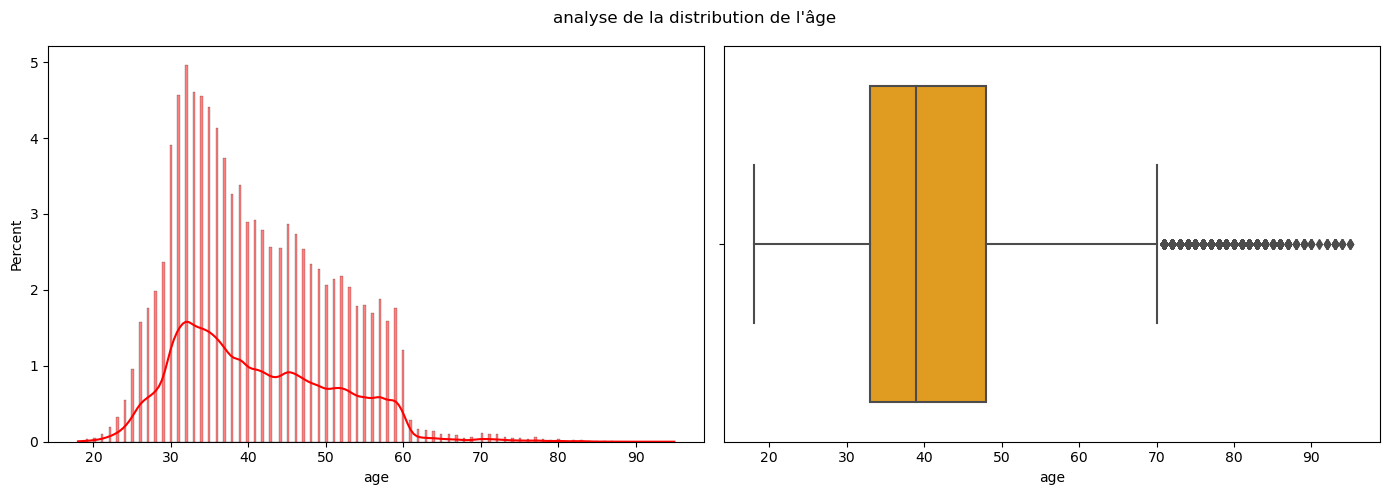

Skew :  1
Age moyen 41


In [27]:
fig,axes = plt.subplots(1,2,figsize=(14,5))
plt.suptitle("analyse de la distribution de l'âge")
sns.histplot(data = df, x ="age", kde=True, color = "red", stat="percent",ax=axes[0])
sns.boxplot(x=df.age, ax = axes[1], color="orange")
plt.tight_layout()
plt.show()
print("Skew : ", round(df.age.skew()))
print("Age moyen", round(df.age.mean()))

In [28]:
df[df.age>70]

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24,24,77,unknown,married,secondary,no,4243,no,no,cellular,12,oct,513,1,91,4,failure,0
110,110,81,retired,married,secondary,no,0,no,no,telephone,16,oct,170,1,-1,0,unknown,0
142,142,72,management,married,secondary,no,0,no,no,cellular,20,apr,5,1,-1,0,unknown,0
255,255,72,retired,married,secondary,no,1162,no,no,cellular,28,jul,199,1,-1,0,unknown,1
393,393,75,retired,married,secondary,no,8304,no,no,cellular,15,mar,653,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747992,747992,71,retired,married,secondary,no,1014,no,no,telephone,16,sep,148,4,-1,0,unknown,0
748029,748029,80,retired,divorced,tertiary,no,0,no,no,cellular,27,jan,150,2,181,5,failure,0
748435,748435,81,retired,married,primary,no,496,no,no,telephone,5,feb,157,4,-1,0,unknown,0
748726,748726,74,retired,married,primary,no,670,no,no,cellular,30,apr,453,5,-1,0,unknown,1


In [29]:
print("Proportion de personne âgé de plus de 70 ans :", round((df.age>70).mean()*100,2),"%")

Proportion de personne âgé de plus de 70 ans : 0.65 %


#### Observation : 
- La majorité de la population concernée dans le jeu de données avoisine 30 ans
- L'age moyen est de 41 ans
- La médiane est à 39, donc peu de différence avec l'âge moyen, ce qui signifie que les outliers sont peut dense 
- La distribution est asymétrique vers la droite avec une queue vers la droite mais avec une faible densité (<1% de la population)

#### duration :

In [30]:
#duration représente la durée de la dernière prise de contact (en secondes)
duration_min = (df.duration).apply(lambda x: x/60) #Transformons là en minute*

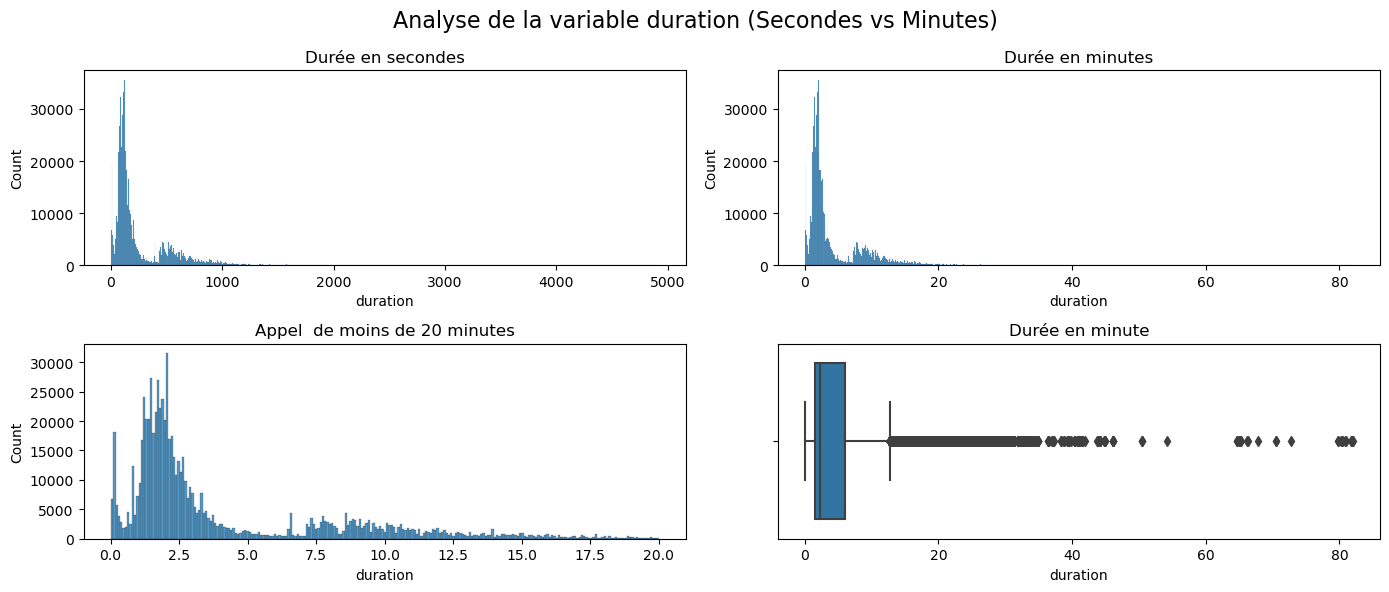

In [31]:
fig = plt.figure(figsize=(14, 6))
plt.suptitle("Analyse de la variable duration (Secondes vs Minutes)", fontsize=16)

# Création d'une grille 2x2
gs = gridspec.GridSpec(2, 2, figure=fig)

# Graphique 1
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(data=df.duration, ax=ax1)
ax1.set_title("Durée en secondes")

# Graphique 2
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data=duration_min, ax=ax2)
ax2.set_title("Durée en minutes")

# Graphique 3 
ax3 = fig.add_subplot(gs[1, 0])  
sns.histplot(data=duration_min[duration_min<=20], ax=ax3)
ax3.set_title("Appel  de moins de 20 minutes")

# Graphique 4
ax4 = fig.add_subplot(gs[1, 1])  #
sns.boxplot(x=duration_min, ax=ax4)
ax4.set_title("Durée en minute")

plt.tight_layout()
plt.show()


In [32]:
print("Temps moyen d'un appel ", round(duration_min.mean()), "minutes")
print("Proportion d'appel ayant durée au moins 40min :", round((df.duration>2400).mean()*100,2),"%")
print("Durée de l'appel le plus long :", round((df.duration.max()/60)),"minutes")

Temps moyen d'un appel  4 minutes
Proportion d'appel ayant durée au moins 40min : 0.01 %
Durée de l'appel le plus long : 82 minutes


In [33]:
df[duration_min>40].sort_values(by = "duration", ascending = False)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
739177,739177,60,management,married,tertiary,no,6573,yes,no,cellular,7,jul,4918,1,-1,0,unknown,1
477980,477980,38,unemployed,single,primary,no,4321,yes,no,cellular,20,nov,4916,1,-1,0,unknown,0
595734,595734,58,retired,single,tertiary,no,792,no,yes,cellular,22,aug,4916,3,-1,0,unknown,0
264264,264264,47,technician,single,tertiary,no,11862,no,no,telephone,20,nov,4914,2,-1,0,unknown,0
113334,113334,50,self-employed,married,secondary,no,1383,yes,no,unknown,15,may,4914,5,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587368,587368,29,technician,single,tertiary,no,4987,yes,no,unknown,8,may,2453,1,-1,0,unknown,1
11650,11650,28,admin.,single,secondary,no,1794,yes,no,telephone,6,may,2452,1,-1,0,unknown,0
343720,343720,23,housemaid,single,secondary,no,829,yes,no,cellular,18,may,2429,1,-1,0,unknown,0
338147,338147,52,admin.,married,secondary,no,652,no,no,unknown,4,jul,2422,1,-1,0,unknown,1


#### Observation : 
- Un appel dure généralement moins de 5 minutes
- Une proportion quasi négligeable à durée plus de 40min
- L'appel le plus long à durée 82 min, 1h22

#### pdays :

On va procéder à différentes manipulation avec la variable afin de pouvoir extraire des informations interessante dessus 

In [34]:
#Récupération des clients jamais contacté : 
pdays_neg = df[df["pdays"]<0]
#récupération des clients ayant été déjà contacté : 
#on selectionne en excluant les lignes des clients jamais contacté
pdays_pos = df[~df.index.isin(pdays_neg.index)]
#On met dans un dictionnaire le nombre de ligne positive et negative pdays
pdays_posneg = {"Negative" : pdays_neg.shape[0],"Positive" : pdays_pos.shape[0]}

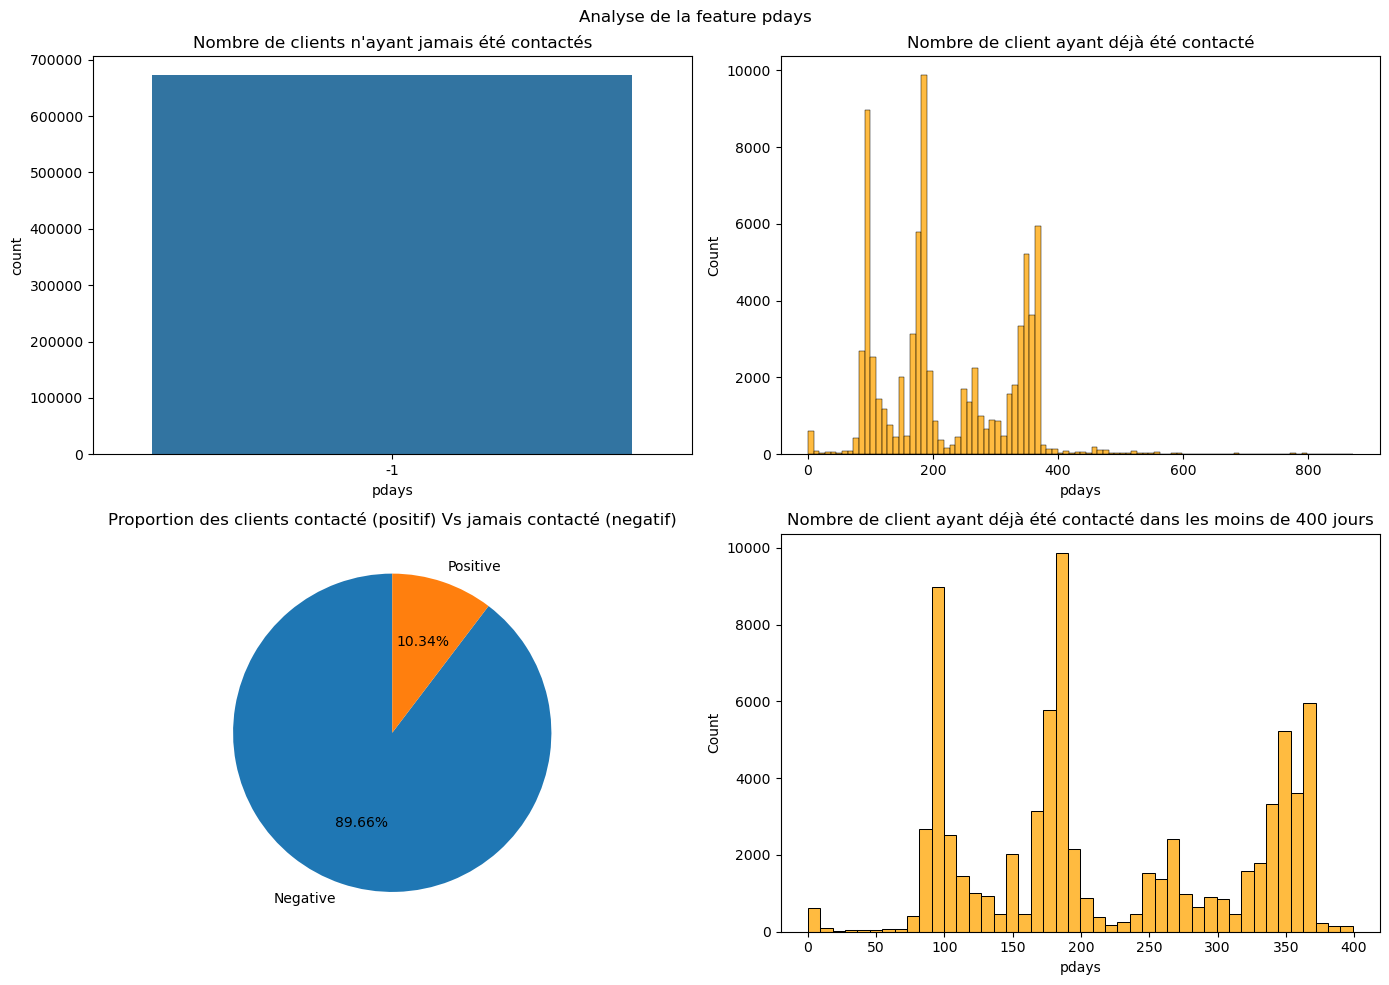

In [35]:
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

plt.suptitle("Analyse de la feature pdays")
#  Graphique 1 : countplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Nombre de clients n'ayant jamais été contactés")
sns.countplot(data = pdays_neg, x= "pdays",  ax=ax1)  
 
#  Graphique 2 : histplot
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data = pdays_pos, x="pdays", ax=ax2, color="orange")
ax2.set_title("Nombre de client ayant déjà été contacté")

#  Graphique 3 : pieplot
ax3= fig.add_subplot(gs[1, 0])
ax3.pie(pdays_posneg.values(),
    labels=pdays_posneg.keys(),
    autopct="%1.2f%%",
    startangle=90
)
ax3.set_title("Proportion des clients contacté (positif) Vs jamais contacté (negatif)")


#  Graphique 4 : histplot
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(pdays_pos[pdays_pos.pdays<400]["pdays"], ax=ax4, color="orange")
ax4.set_title("Nombre de client ayant déjà été contacté dans les moins de 400 jours")


plt.tight_layout()
plt.show()


#### Observation : 
- pour les clients ayant déjà été contacté, on remarque qu'on a un pic environ tous les 100 jours
- quasi 700.000 jamais contacté
- Soit 90% des clients n'ont jamais été contacté; quasi les mêmes proportions que la target (90% des clients qui n'ont pas souscrit)
- On peut déduire que cette base de données contient de nouveau client potentiels
- 

#### balence :
- Cette variable qui pour rappel, est le solde annuel moyen (en €)

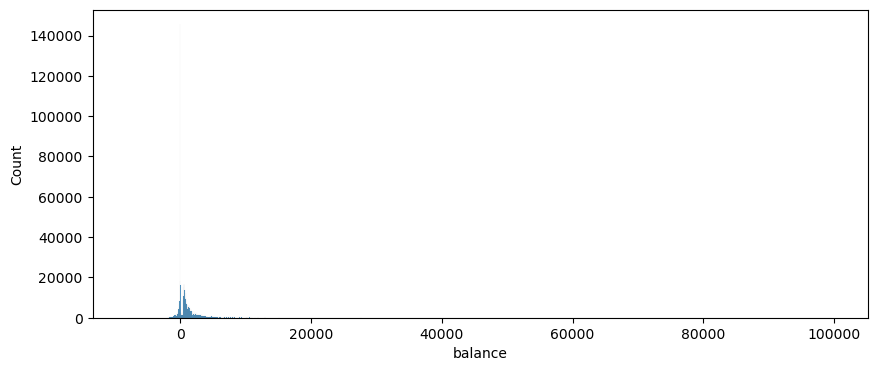

In [36]:
plt.figure(figsize=(10,4))
sns.histplot(data = df, x = "balance")
plt.show()

- La figure est difficile à analyser, comme nous l'avions vu précédemment, elle possède une large étendue, nous allons la scinder en plusieurs sous variable pour mieux l'analyser 

In [37]:
neg_bal = df.loc[(df.balance < -2000),]
neg_mid_bal = df.loc[(df.balance>-2000) & (df.balance<0)]
pos_mid_bal = df.loc[(df.balance<6000) & (df.balance>0)]
pos_bal = df.loc[(df.balance > 6000) & (df.balance<20000)]
rich_bal = df.loc[(df.balance > 20000)]

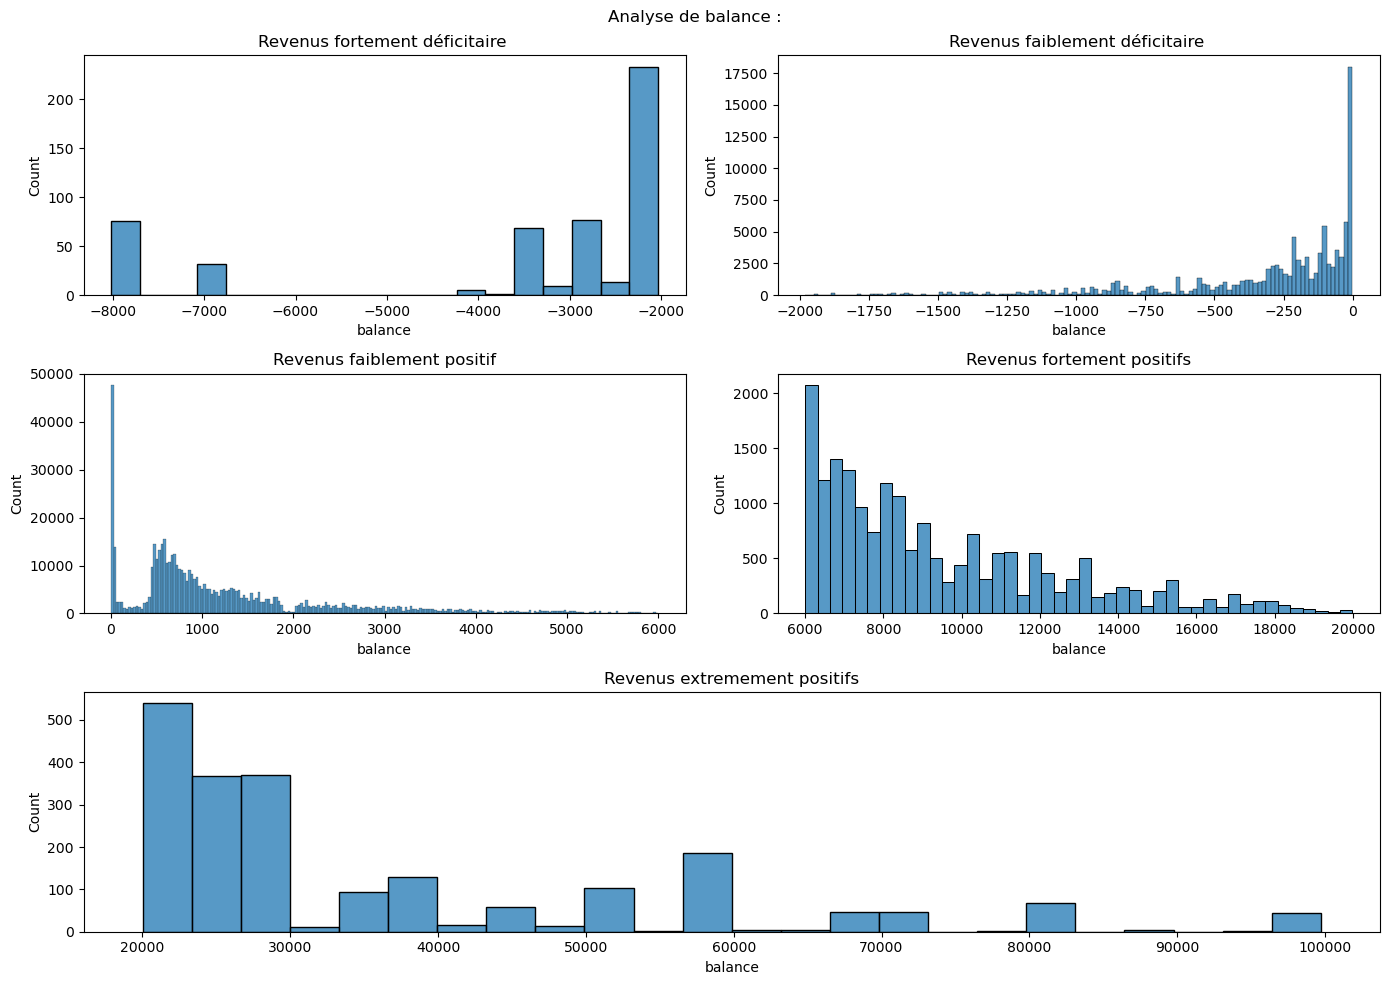

In [38]:
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(3,2, figure=fig)

plt.suptitle("Analyse de balance :")

#  Graphique 1 :
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Revenus fortement déficitaire ")
sns.histplot(neg_bal, x = "balance", ax=ax1)
 
#  Graphique 2 :
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(neg_mid_bal, x = "balance", ax=ax2)
ax2.set_title("Revenus faiblement déficitaire ")

#  Graphique 3 :
ax3= fig.add_subplot(gs[1, 0])
sns.histplot(data = pos_mid_bal, x = "balance", ax=ax3 )
ax3.set_title("Revenus faiblement positif")


#  Graphique 4 : 
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(pos_bal, x = "balance",  ax=ax4)
ax4.set_title("Revenus fortement positifs")

# Graphique 5
ax5 = fig.add_subplot(gs[2, :])
sns.histplot(rich_bal, x = "balance",   ax=ax5)
ax5.set_title("Revenus extremement positifs")


plt.tight_layout()
plt.show()


#### Observation : 
- On voit des valeur très dispercées : entre les clients de la base de données qui ont des revenus à découvert, et des clients ayant des soldes annuelle à haute valeur
- On peut noter que la majorité des clients se situe aux alentours de 0 ( avec une tendance pour des valeurs positif plutôt que négatifs)

- Dans la partie bivariée,  On pourrait regarder la proportion de personnes ayant un déficit annuelle qui souscrit à un prêt Vs les positifs

#### Features qualitatives :     
- Dans un premier temps regardons le nombre de modalité prises par nos variables

In [39]:
df[var_qual].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

- Au maximum, 12 modalités différentes, ce qui reste relativement faible, donc nous n'aurons pas besoin de réduire leur nombre afin d'afficher correctement les graphiques

In [41]:
def multi_countplot(data, columns, nrow,ncol, figsize=(14,6)):
    """Fonction qui trace des countplots
    data : dataframe
    columns : list contenant le nom des colonnes
    nrow : int nombre de ligne 
    ncol : int nombre de colonne
    figsize : taille des figures
    """
    plt.figure(figsize=figsize)
    for idx,col in enumerate(columns,1):
        plt.subplot(nrow,ncol, idx)
        if data[col].nunique()>6:#si la feature prend plus de 6 modalités 
            #on effectuera une rotation des labels afin de faciliter la lecture du graphique
            ax = sns.countplot(data=data, x=col)
            labels = [label.get_text() for label in  ax.get_xticklabels()]
            ax.set_xticklabels(rotation = 90, labels=labels)
        else:
            sns.countplot(data=data, x = col)        
    plt.tight_layout()
    plt.show()

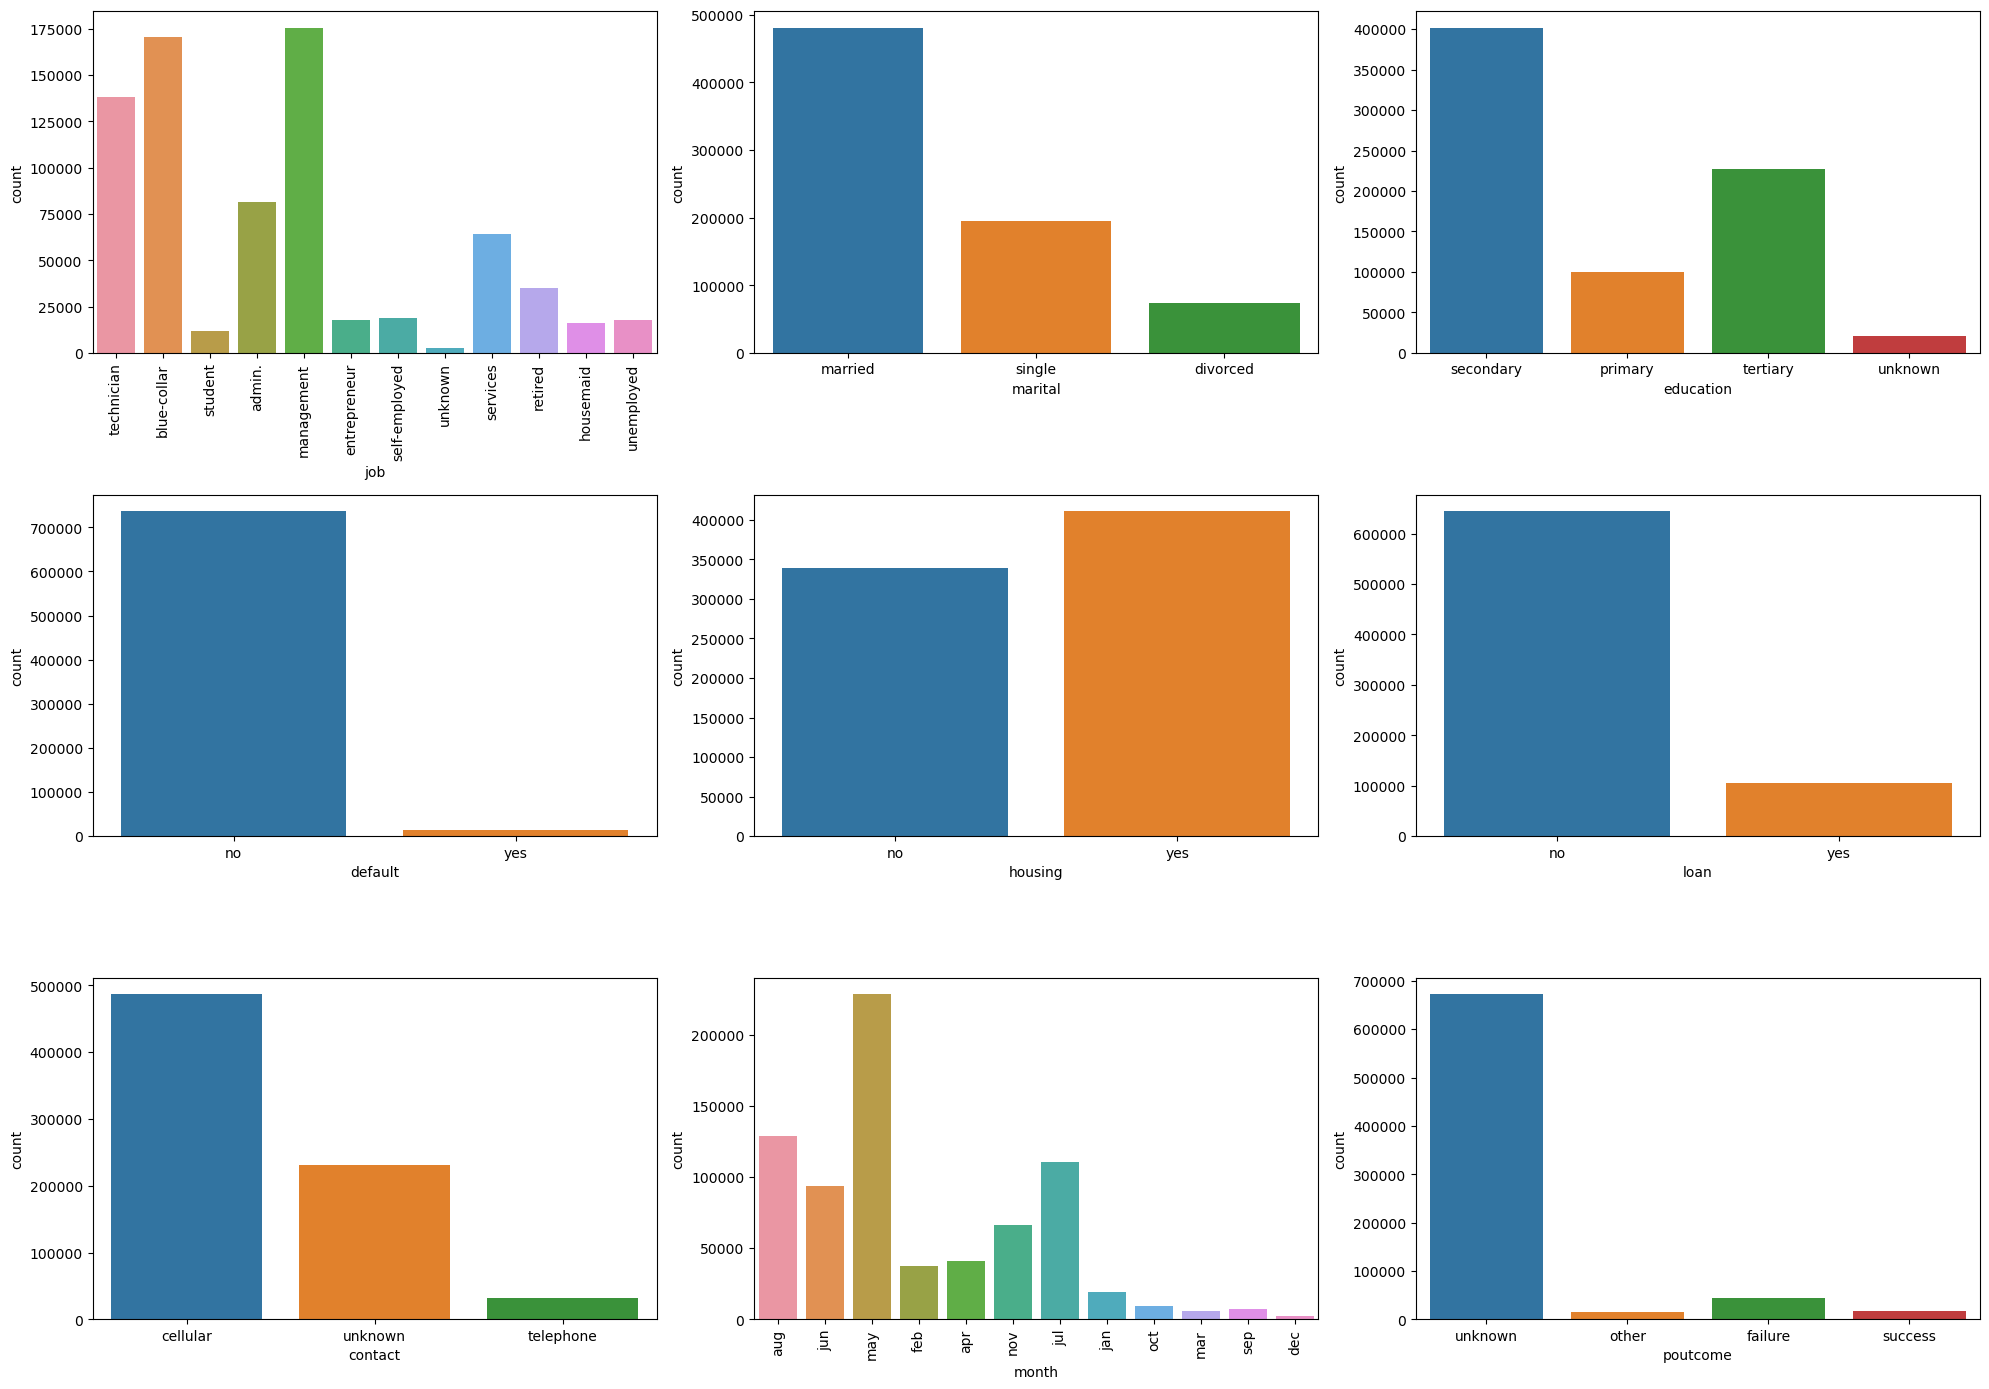

In [42]:
multi_countplot(df, var_qual,3,3,figsize=(20,14))

#### Observation : 
- **job** : Les 3 métiers les plus présents sont ouviers (blue-collar), technicien et management
- **marital** : environ 1/3 de personne mariée
- **education** : la majeur partie on un niveau lycée suivi du niveau d'étude supérieur
- **default** : plus de 90% des individus sont en règles concernant les défauts de paiement
- **housing** : plus de la moitié des individus sont sous le coup d'un prêt immobilier
- **loan** : 600k individus n'ont pas de prêt personnel en plus en cours
- **contact** : la communication est essentiellement faite sur telephone cellulaire. On peut noter qu'environ 200k individus pour lesquels on ne sait pas comment ils sont contactés
- **month** : les individus son surtout contacté au mois de juin
- **poutcome** : Ici + de 90% de unkown, ce qui signifie qu'on ne connait pas l'issue du résultat de la campagne marketing précédente sur quasi la totalité des clients

### 2.2 Analyse bivariée : target Vs features
- Analysons l'influence de la target sur les features

#### Target & variable  discrètes : 
- discrète (ou qualitative) / discrète (ou qualitative) : heatmap, barplot groupé, barplot empilé

In [43]:
df[var_dis].nunique()

day         31
campaign    52
previous    49
y            2
dtype: int64

- Comme ces features prennent un nombre de modalité assez conséquent, on va plutôt les afficher avec des barplot empilé avec les **proportions**

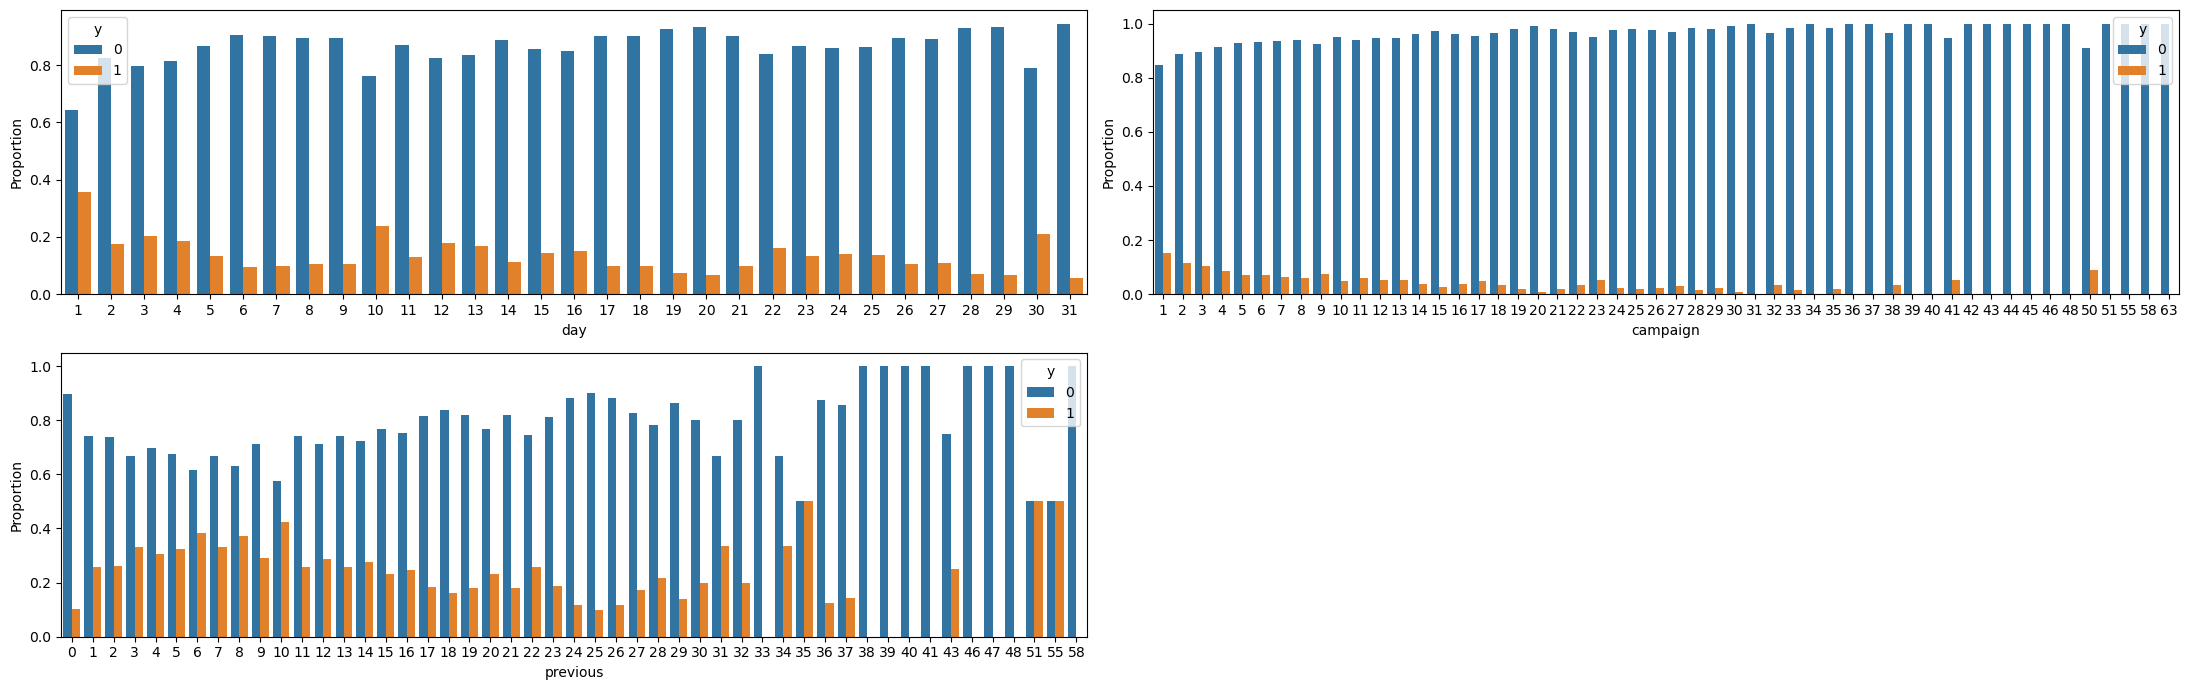

In [44]:
plt.figure(figsize=(22,7))
for i, k in enumerate(var_dis, 1):
    if k != "y":
        plt.subplot(2, 2, i)
        
        # Crosstab normalisée ligne par ligne (proportions par modalité de k)
        cross = pd.crosstab(df[k], df["y"], normalize="index").reset_index()
        
        # Transformation au format long
        cross = cross.melt(id_vars=k, var_name="y", value_name="proportion")
        
        # Barplot en proportions
        sns.barplot(x=k, y="proportion", hue="y", data=cross)
        plt.ylabel("Proportion")

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Proportion')

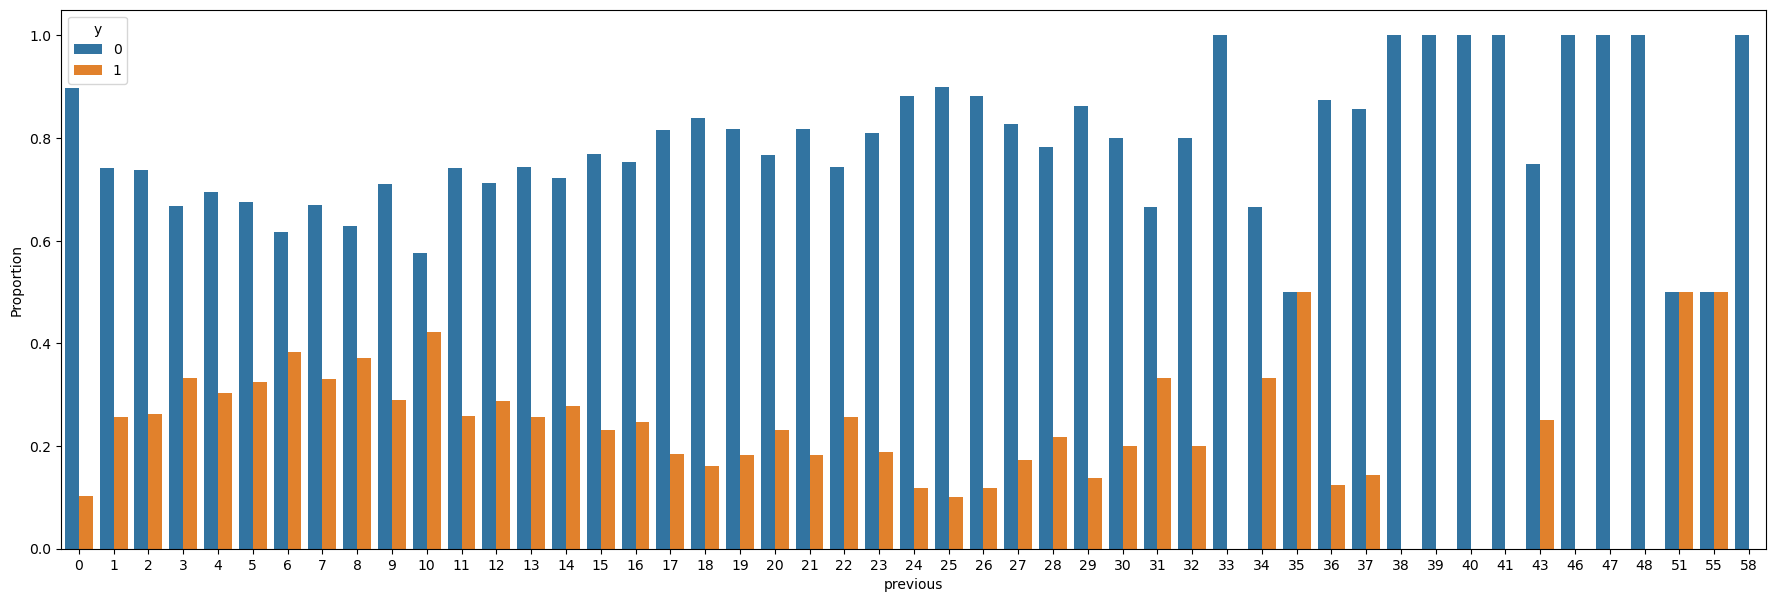

In [45]:
plt.figure(figsize=(22,7))

# Crosstab normalisée ligne par ligne (proportions par modalité de k)
cross = pd.crosstab(df["previous"], df["y"], normalize="index").reset_index()
        
        # Transformation au format long
cross = cross.melt(id_vars="previous", var_name="y", value_name="proportion")
        
# Barplot en proportions
sns.barplot(x="previous", y="proportion", hue="y", data=cross)
plt.ylabel("Proportion")


#### Observation :
Sachant qu'on a des données déséquilibré, ce qui va nous interessé c'est la variation de la proportion de chaque modalité 
- day : le 1er jour, on a quasiment 40% de client qui souscrive à un placement d'argent (y=1), puis on voit une diminution de la valeur qui va osciller à 20% en moyenne
- Campaign : de même pour cette variable, le 1er jour on aura la valeur la plus élevée avec ~ 18%, puis une diminution progressive
- previous : à l'inverse ici pour previous, si aucune campagne à été effectuée, pour la valeur 0, on retrouve ~ 10% de souscription pour placer son argent. Puis plus la valeur previous augmente et plus la chance de souscription (y=1) augmente. Ensuite on va avoir une diminution. On peut apercevoir qu'a certaine valeur on a du 50/50 (j35, 51 & 55)

Ce qu'on peut conclure ici, c'est qu'on observe **une variation de la proportion de la target y en fonction des différentes modalités de chaques features testées (var_dis) qui nous indique qu'il y a de forte chance qu'il existe une dépendance features-target**


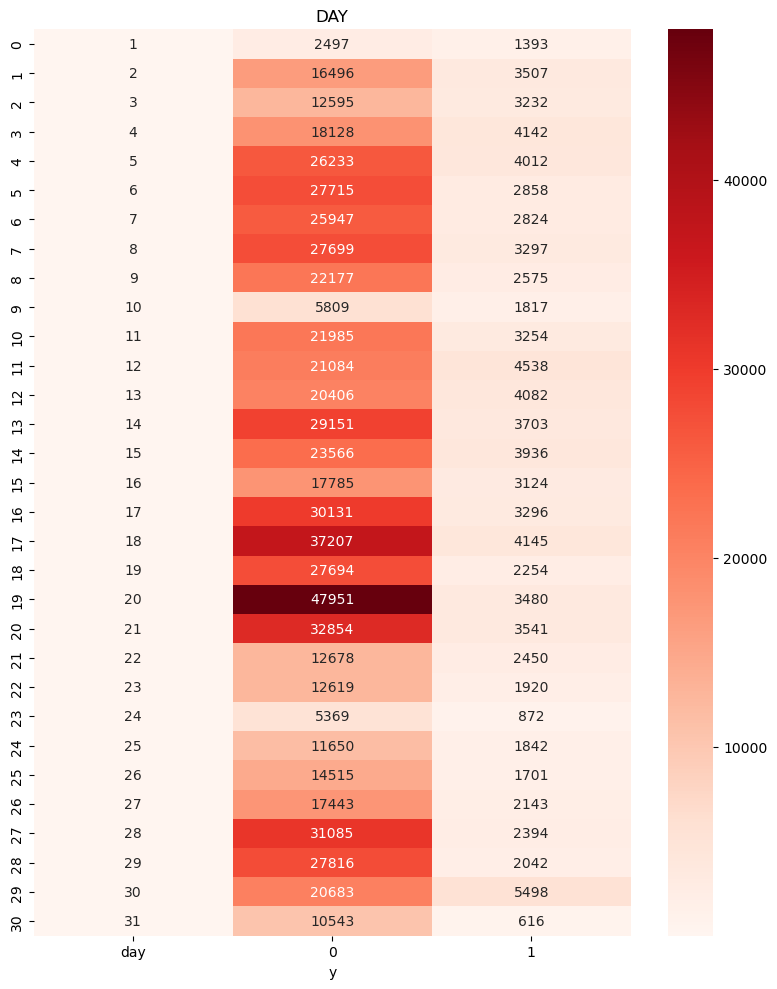

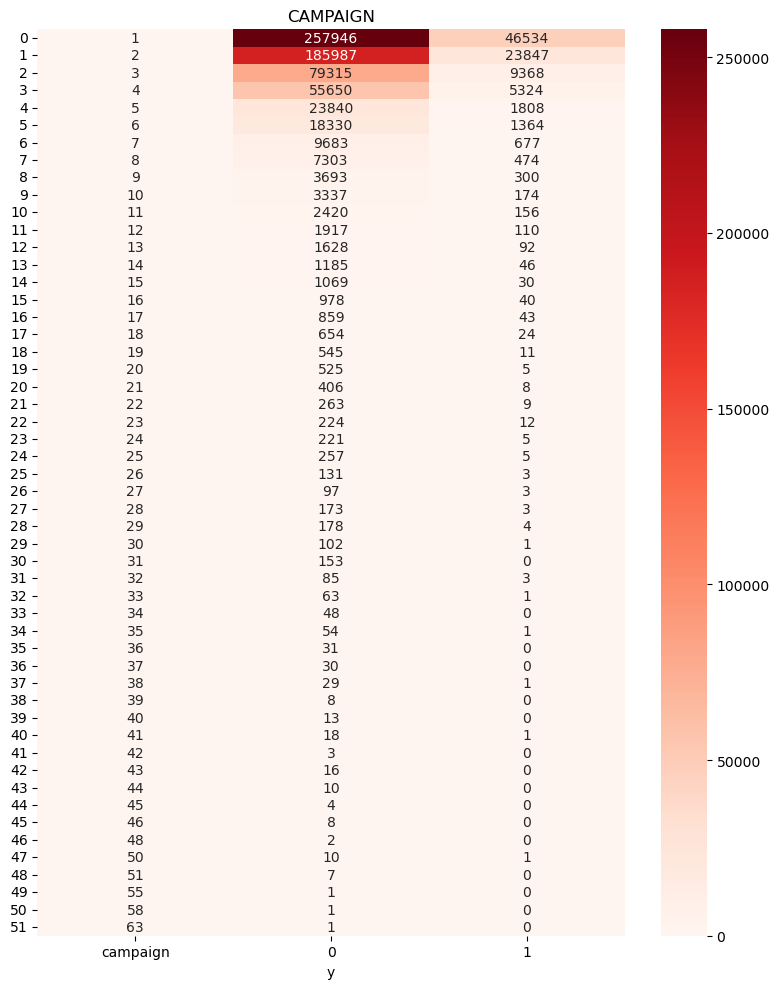

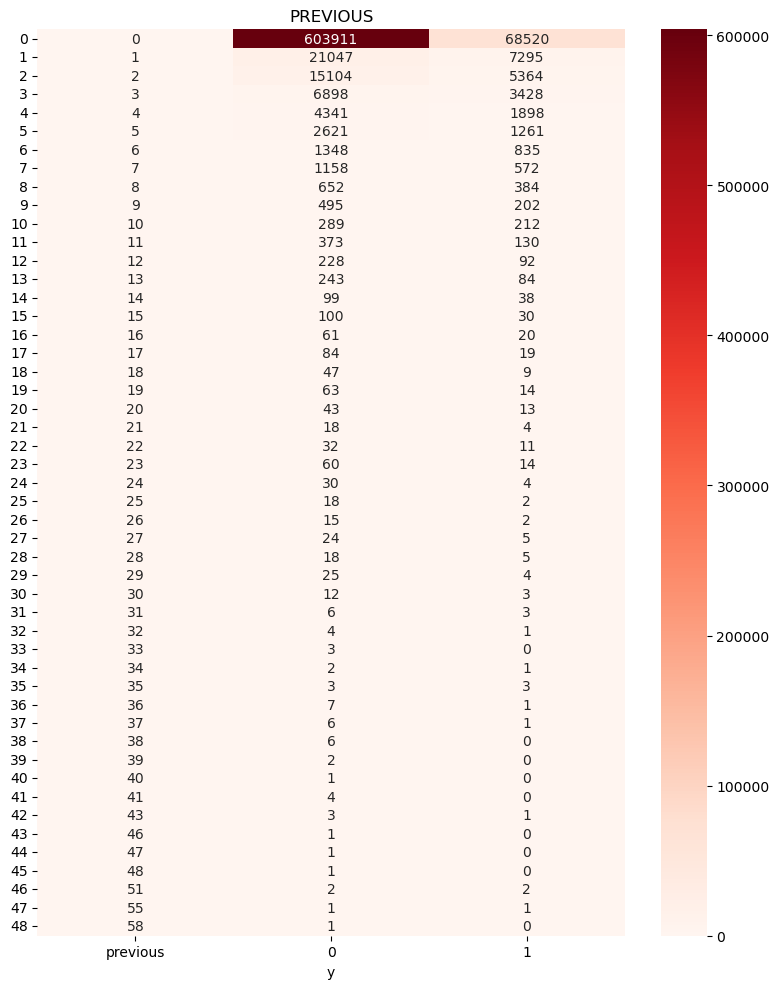

In [46]:
#Visualisation d'une heatmap 
for i in var_dis:
    if i!=df.y.name:
        plt.figure(figsize=(8,10))
        plt.title(f"{i.upper()}")
        cross = pd.crosstab(df[i],df["y"])
        cross = cross.reset_index()
        sns.heatmap(cross, fmt = "d", cmap="Reds",  annot=True)
        plt.tight_layout()
        plt.show()

#### Target & variable  continues : 
- On va récupérer les mêmes figures que dans la partie analyse univariée et simplement rajouter la target et voir son influence

##### age : 

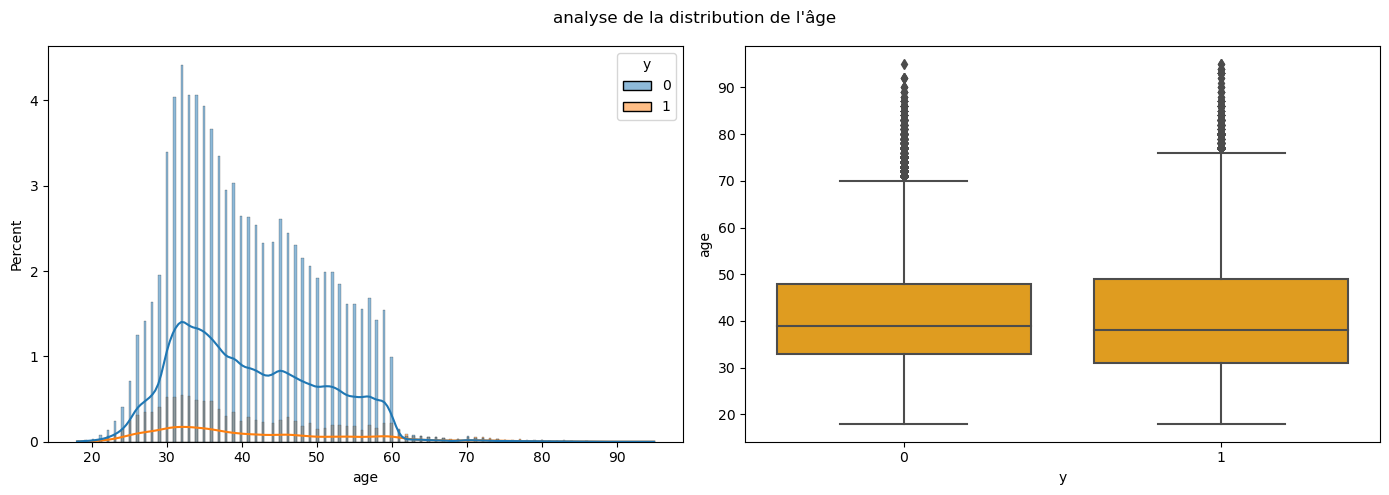

Skew :  1
Age moyen 41


In [47]:
fig,axes = plt.subplots(1,2,figsize=(14,5))
plt.suptitle("analyse de la distribution de l'âge")
sns.histplot(data = df, x ="age", hue="y", kde=True,  stat="percent",ax=axes[0])
sns.boxplot(data=df, x="y", y ="age", ax = axes[1], color="orange")
plt.tight_layout()
plt.show()
print("Skew : ", round(df.age.skew()))
print("Age moyen", round(df.age.mean()))

#### Observation : 

- Entre 25 et 35 ans, on voit une légère surreprésentation (courbe orange un peu plus épaisse)

- Les médianes des âges sont assez proches pour y=0 et y=1.

- Cependant, la distribution de y=1 semble légèrement décalée vers des âges plus jeunes (boîte un peu plus basse).

- La dispersion est similaire, avec des outliers sur les âges élevés dans les deux cas.

##### pdays : 


In [48]:
# Parmis les clients jamais contacté auparavant, calculons le % ayant fait un dépot : 
pdays_neg_y = pdays_neg[["pdays","y"]].groupby("y").count().reset_index()
pdays_neg_y["pourcent"] = pdays_neg_y.pdays.apply(lambda x : x/pdays_neg.shape[0])


In [49]:
pdays_pos_y = pdays_pos[["pdays","y"]].groupby("y").count().reset_index()
pdays_pos_y["pourcent"] = pdays_pos_y.pdays.apply(lambda x : x/pdays_pos.shape[0])


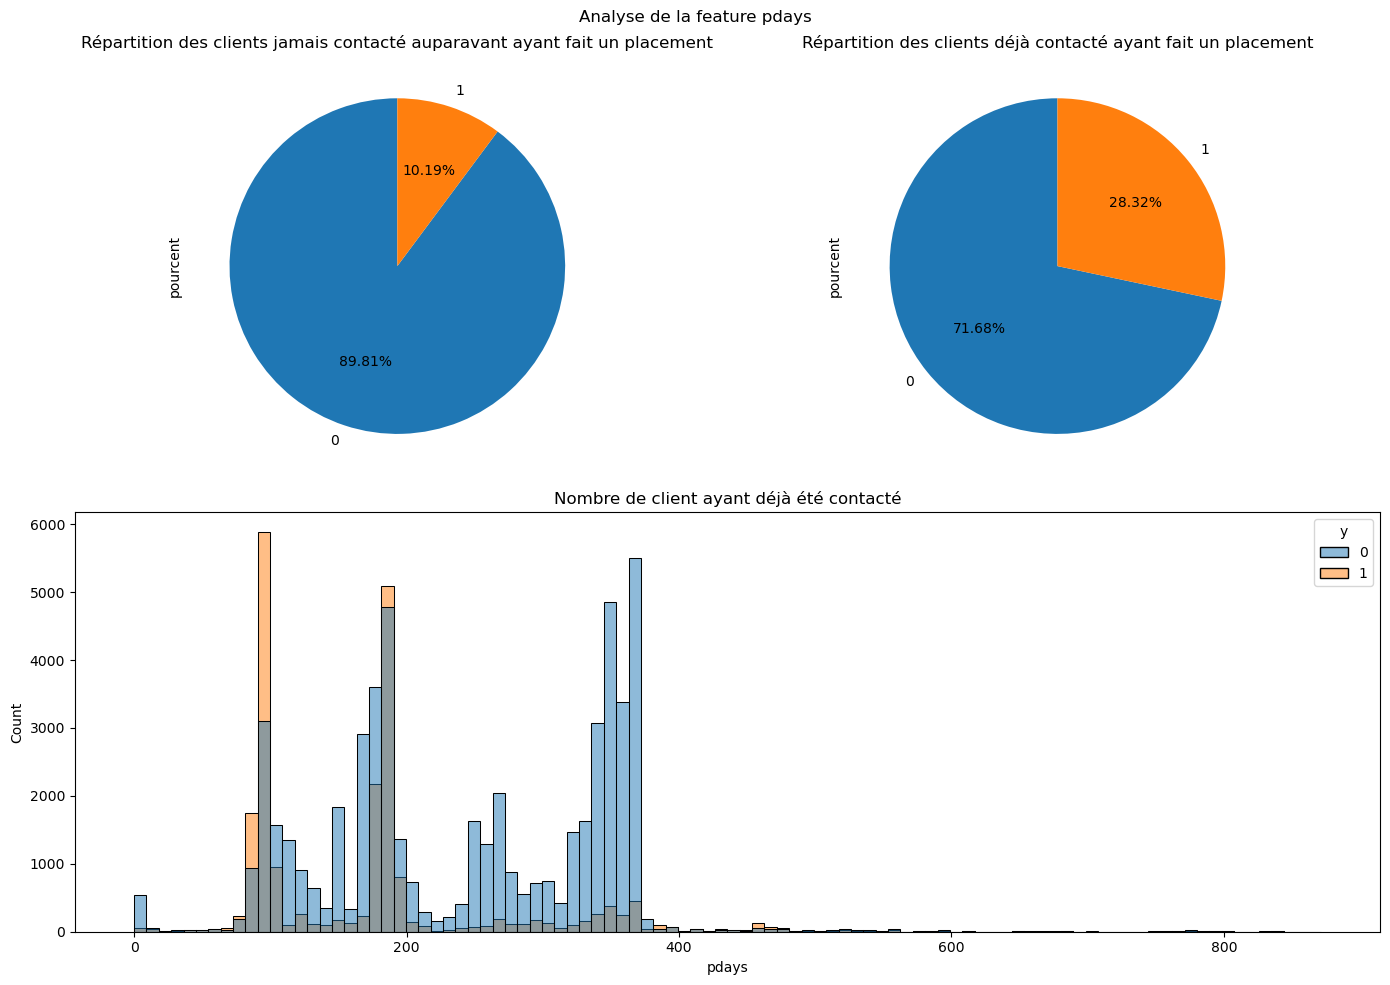

In [50]:
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

plt.suptitle("Analyse de la feature pdays")
#  Graphique 1 : countplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Répartition des clients jamais contacté auparavant ayant fait un placement")
pdays_neg_y["pourcent"].plot.pie(autopct="%1.2f%%",
    startangle=90)

#  Graphique 2 : histplot
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title("Répartition des clients déjà contacté ayant fait un placement")
pdays_pos_y["pourcent"].plot.pie(autopct="%1.2f%%",
    startangle=90)

# #  Graphique 3 : pieplot
ax3 = fig.add_subplot(gs[1,:])
sns.histplot(data = pdays_pos, x="pdays", hue = "y", ax=ax3, color="orange")
ax3.set_title("Nombre de client ayant déjà été contacté")
"Proportion des clients contacté (positif) Vs jamais contacté (negatif)"


# #  Graphique 4 : histplot
# ax4 = fig.add_subplot(gs[1, 1])
# sns.histplot(pdays_pos[pdays_pos.pdays<400]["pdays"], ax=ax4, color="orange")
# ax4.set_title("Nombre de client ayant déjà été contacté dans les moins de 400 jours")


plt.tight_layout()
plt.show()


#### Observation : 
- Graph 1 :  Parmis les clients qui n'ont jamais été contacté, seul 10% ont fait un placement
- Graph 2 :  A l'inverse, ce qui ont déjà été contacté, on monte jusqu'à 30%

- Graph 3 : On peut voir que sur la distribution, qu'on obtient les valeurs élevées en placement de fond autour de 100jours et 200 jours

Donc on peut dire qu'il faut en moyenne une centaines de jours pour qu'un client décide de faire un placement d'argent

##### balance :

In [57]:
#rajoutons une catégorie pour mieux visualiser :
pos_faible_bal = df[(df.balance>0) & (df.balance <1000)]

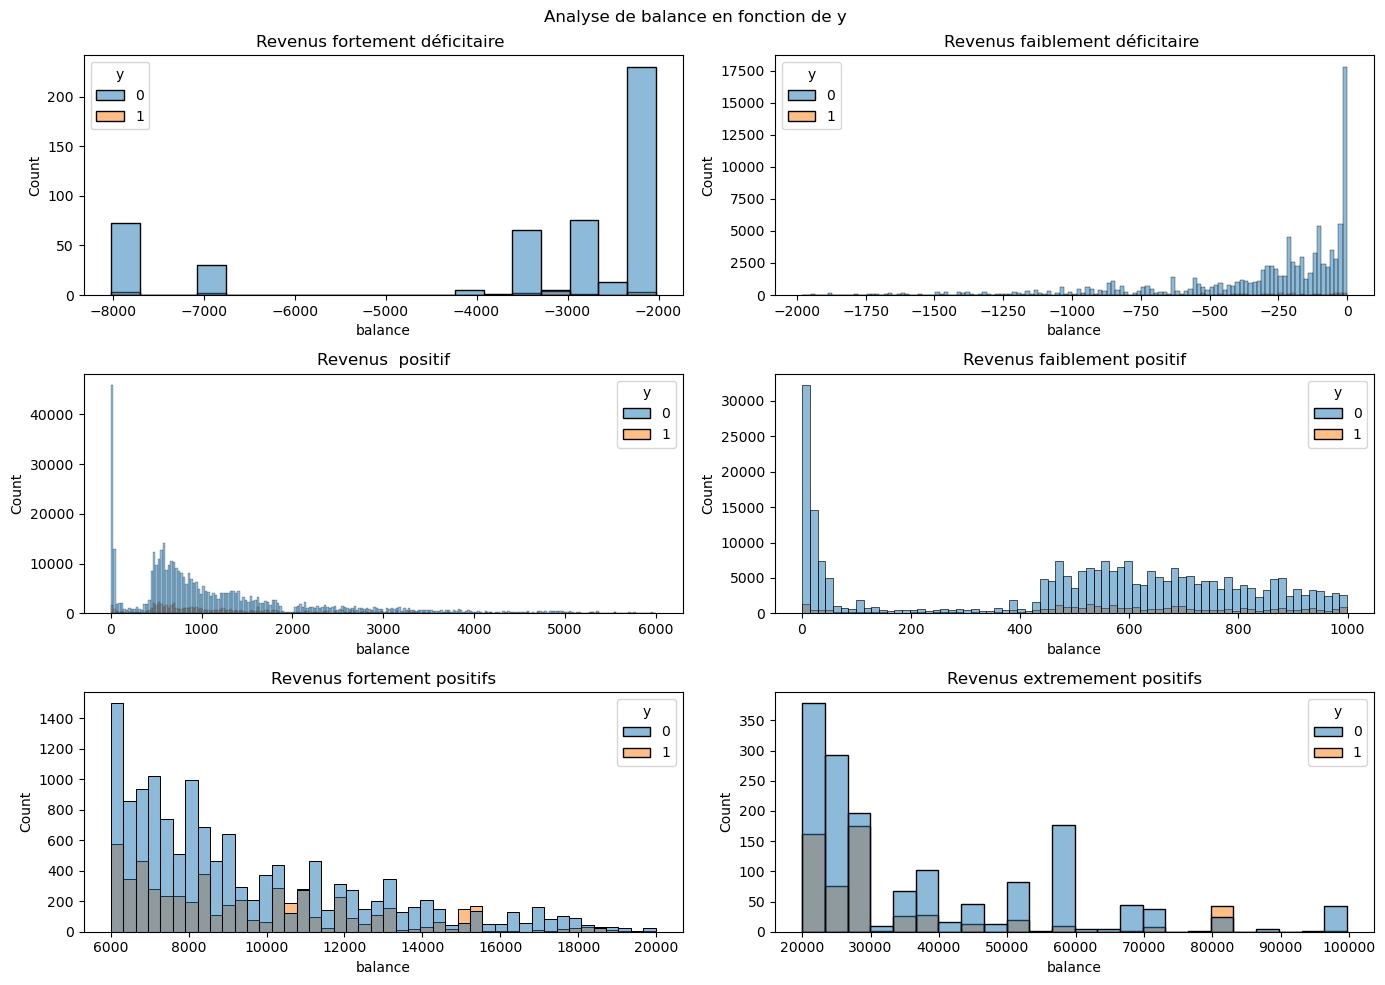

In [58]:
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(3,2, figure=fig)

plt.suptitle("Analyse de balance en fonction de y")

#  Graphique 1 :
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Revenus fortement déficitaire ")
sns.histplot(neg_bal, x = "balance", hue = "y", ax=ax1)
 
#  Graphique 2 :
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(neg_mid_bal, x = "balance", hue = "y", ax=ax2)
ax2.set_title("Revenus faiblement déficitaire ")

#  Graphique 3 :
ax3= fig.add_subplot(gs[1, 0])
sns.histplot(data = pos_mid_bal, x = "balance",hue = "y", ax=ax3 )
ax3.set_title("Revenus  positif")


#  Graphique 4 : 
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(data = pos_faible_bal, x = "balance",hue = "y", ax=ax4 )
ax4.set_title("Revenus faiblement positif")



#  Graphique 5 : 
ax5 = fig.add_subplot(gs[2, 0])
sns.histplot(pos_bal, x = "balance",  hue = "y", ax=ax5)
ax5.set_title("Revenus fortement positifs")





# Graphique 6
ax6 = fig.add_subplot(gs[2, 1])
sns.histplot(rich_bal, x = "balance", hue = "y",   ax=ax6)
ax6.set_title("Revenus extremement positifs")


plt.tight_layout()
plt.show()


#### Observation : 
- Pour les valeurs négative de balance on ne compte quasiment pas de client ayant placé un fond
- On commence à voir un peu de client pour des valeurs jusqu'à <6000
- à partir de 6000, on voit des valeurs y=1 plus conséquente par rapport aux clients y=0

In [76]:
df_temp = df.copy()

In [77]:
df_temp["duration_min"] = df.duration/60

<Axes: xlabel='y', ylabel='duration'>

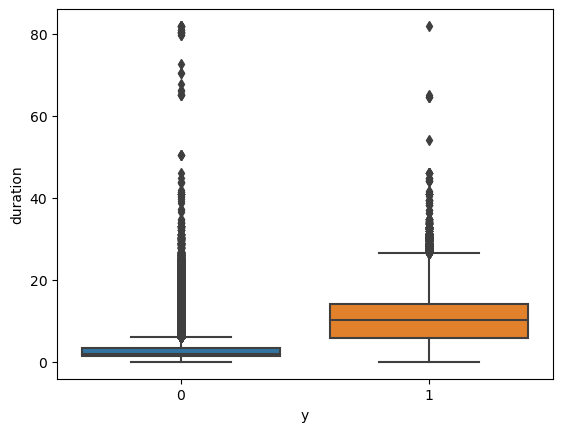

In [89]:
sns.boxplot(data = df, y=duration_min, x="y")


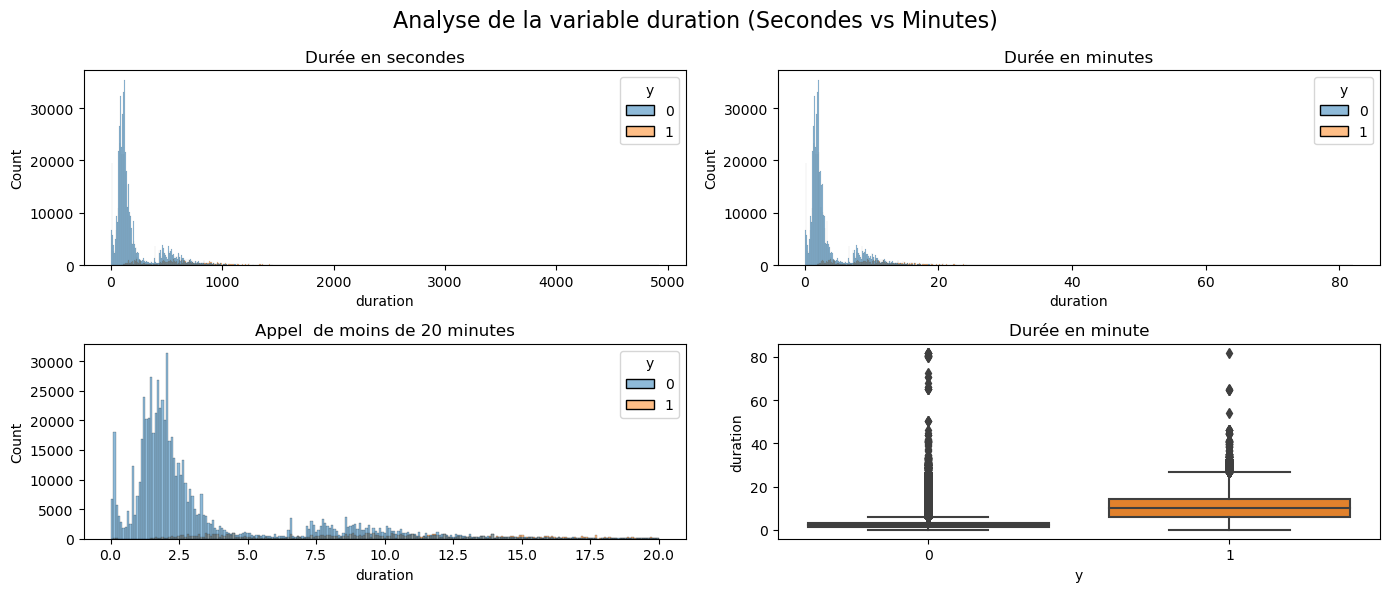

In [90]:
fig = plt.figure(figsize=(14, 6))
plt.suptitle("Analyse de la variable duration (Secondes vs Minutes)", fontsize=16)

# Création d'une grille 2x2
gs = gridspec.GridSpec(2, 2, figure=fig)

# Graphique 1
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(data=df, x = "duration", hue = "y", ax=ax1)
ax1.set_title("Durée en secondes")

# Graphique 2
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(x=duration_min, hue = df["y"], ax=ax2)
ax2.set_title("Durée en minutes")

# Graphique 3 
ax3 = fig.add_subplot(gs[1, 0])  
sns.histplot(x=duration_min[duration_min<=20],hue = df["y"], ax=ax3)
ax3.set_title("Appel  de moins de 20 minutes")

# Graphique 4
ax4 = fig.add_subplot(gs[1, 1]) 
sns.boxplot(data = df,x="y" ,y=duration_min , ax=ax4)
ax4.set_title("Durée en minute")

plt.tight_layout()
plt.show()


#### Observation : 
- On peut voir que les clients ayant fait un placement reste au téléphone plus longtemps que ceux qui ne l'ont pas fait.
- On voit qu'à partir de 10/12 minutes qu'il y a plus d'individus avec y=1 que y=0.
- Les clients n'ayant pa fait de placement raccroche majoritairement au bout de 2minutes. Ils ne sont pas intéressé et la conversation ne dure pas

#### Target & variable  qualitatives : 
- discrète (ou qualitative) / discrète (ou qualitative) : heatmap, barplot groupé, barplot empilé


In [95]:
def barplot2(feat,target, stacked=False):
    """
    Fonction permettant d'obtenir un barplot en fonction de 2 variables qualitative/discrète
    La normalisation se fait en fonction de la variable 'target'
    (si on veut normaliser par la feature, il suffit d'inverser les paramètres "feat" & "target")
    """
    # Calculer les comptages groupés
    grouped_counts = df.groupby([target,feat]).size().unstack()

    # Normalisation par "target"
    normalized_by_group = grouped_counts.div(grouped_counts.sum(axis=1), axis=0) * 100

    #  graphique en barres empilées normalisé par la target
    ax1 = normalized_by_group.plot(kind="bar", stacked=stacked)
    ax1.set_ylabel(f'Pourcentage (%) - Normalisé par {target}')
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.1f%%')
    plt.title(f'Normalisation par {target}')
    plt.show()

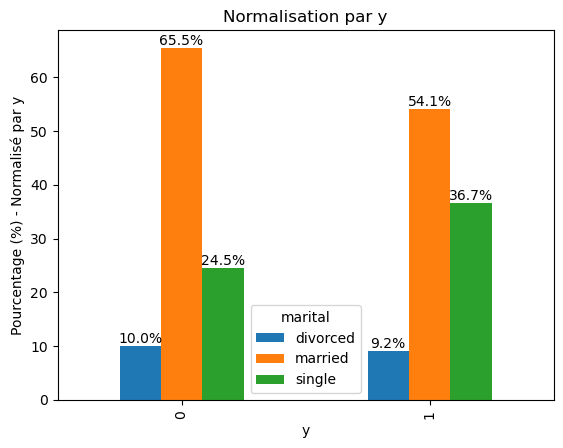

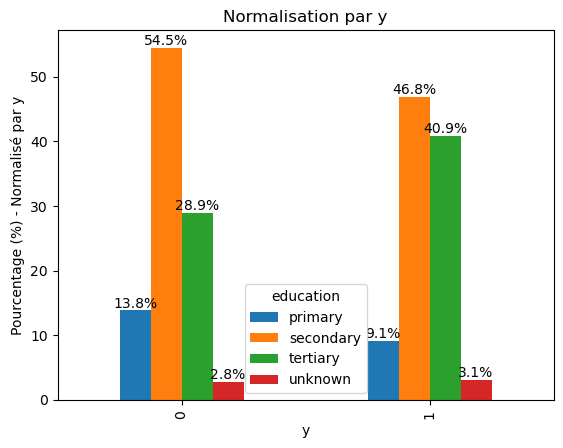

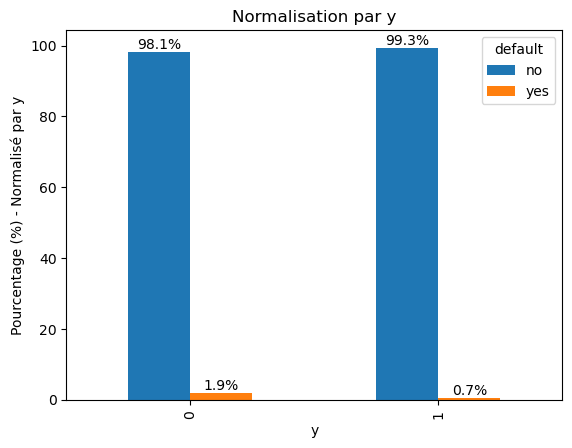

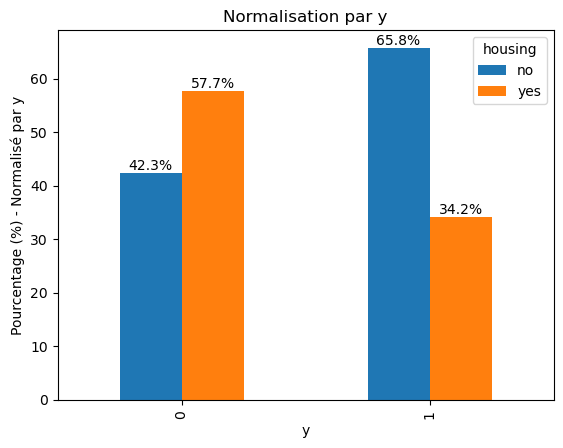

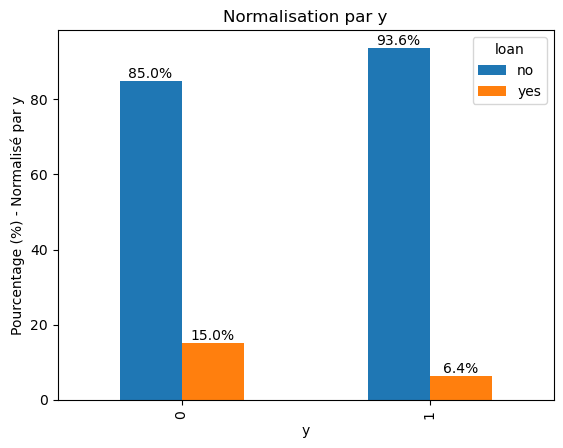

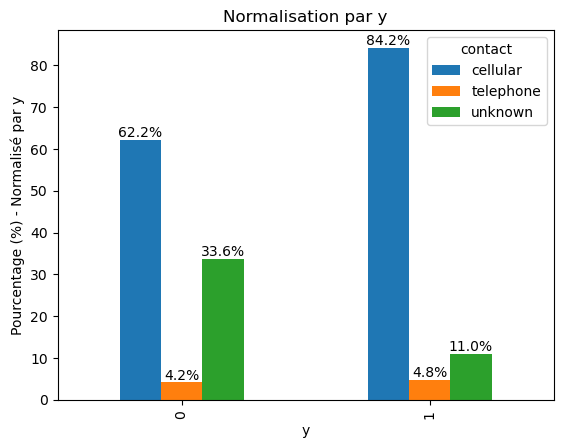

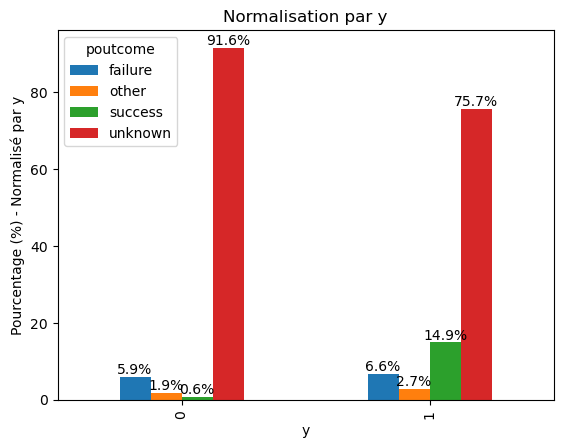

In [96]:
for i in var_qual:
    if (i !="y") & (df[i].nunique()<10):
        barplot2(i,"y",)

#### Observation : 
- le pattern suivi entre les personnes ayant souscrit ou non reste globalement le même à l'exception de la feature housing ou la tendance s'inverse complètement : les clients ayant souscrit à un placement n'ont, pour la grande majorité, pas de prêt immobilier

# 3. Test statistique : 

- Maintenant que la nous avons effectué la datavisualisation, nous allons pouvoir adapter les tests statistiques à effectuer :
	- Cas 1 : 2 features discrètes/qualitatives
		- test du Chi2
	- Cas 2 : 1 feature de chaque type avec la target ne prenant que 2 modalités 
		- Variables qui ne suivent pas une loi  normale : test Man Whitney
        - variables qui suivent une loi  loi normale + égalité variance : test Student
        - variables qui suivent une loi  loi normale + non égalité variance : test Welch


- Pour vérifier la dépendance, on pose H0 : variables indépendantes. Si pval<risque seuil (alpha), on rejette H0 pour la réciproque H1 avec un risque inférieur au seuil posé.	

#### 3.1 Shapiro Wilk 
- Nous allons dans un premier temps déterminé si nos variables continues suivent ou non une loi normal, afin d'orienter la suite des tests : 

In [97]:
def shapiro_test(list_col):
    """
    Cette fonction teste si list_col est une liste, si ce n'est pas le cas,
    elle convertie le texte en une liste avant de faire un test shapiro pour vérifier
    si la feature suit une loi normale ou non
    """
    if type(list_col) != list:
        list_col = [list_col]

    accepted,rejected = [], []

    for col in df[list_col]:
        stat, p_value = shapiro(df[col])  
        alpha = 0.05
        if p_value > alpha: 
            result = colored('Accepter', 'green')  
            accepted.append(col)
        else:
            result = colored('Rejet','red')        
            rejected.append(col)

        print(f'{col:-<50}\t Hypothèse: {result}')
    return accepted,rejected

In [102]:
shapiro_test(var_cont)

age-----------------------------------------------	 Hypothèse: Rejet
balance-------------------------------------------	 Hypothèse: Rejet
duration------------------------------------------	 Hypothèse: Rejet
pdays---------------------------------------------	 Hypothèse: Rejet


([], ['age', 'balance', 'duration', 'pdays'])

#### Observation : 
- Aucune feature ne suit de loi normale

### Conclusion pour le choix des test : 
- Target Vs variables continues : **Test Man Whitney**
- Target Vs variables discrètes + qualitatives : **Test du Chi2**

In [110]:
def khi2(data, features, target):
    """
    Applique un test du chi2 d'indépendance entre une ou plusieurs variables qualitatives (features)
    et une variable cible (target).

    Paramètres
    ----------
    data : pd.DataFrame
        Jeu de données contenant target et features.
    features : str | list
        Nom(s) des variables explicatives qualitatives.
    target : str
        Nom de la variable cible quxalitative.

    Retour
    ------
    (var_a_conserver, var_a_supprimer) : tuple(list, list)
        Variables jugées dépendantes de target (à conserver) 
        et indépendantes de target (à supprimer).
    """
    var_a_supprimer = []
    var_a_conserver = []
    
    # Si features est un seul nom de variable, on le transforme en liste
    if not isinstance(features, (list, tuple, np.ndarray, pd.Index)):
        features = [features]
    
    print(colored("P-values du test du Chi² :\n", "magenta", attrs=["bold"]))
    
    for feature in features:
        alpha = 0.05
        df_temp = pd.crosstab(data[target], data[feature])
        pval = chi2_contingency(df_temp)[1]
        
        if pval < alpha:
            var_a_conserver.append(feature)  # rejet de H0 : dépendance
            print(f"{colored(feature,'green',attrs=['bold'])} : {pval:.4f}")
        else:
            var_a_supprimer.append(feature)  # non rejet de H0 : indépendance
            print(f"{colored(feature,'light_red', attrs=['bold'])} : {pval:.4f}")
    
    print()
    print(colored("Variables à conserver :", "green", attrs=["bold"]), var_a_conserver)
    print(colored("Variables à supprimer :", "red", attrs=["bold"]), var_a_supprimer)
    
    return var_a_conserver, var_a_supprimer


In [120]:
khi2(df, var_cont+var_dis, "y")

P-values :

age : 0.0
balance : 0.0
duration : 0.0
pdays : 0.0
day : 0.0
campaign : 0.0
previous : 0.0
y : 0.0

Variable a conserver  ['age', 'balance', 'duration', 'pdays', 'day', 'campaign', 'previous', 'y']
Variable a supprimer  []


(['age', 'balance', 'duration', 'pdays', 'day', 'campaign', 'previous', 'y'],
 [])

In [ ]:
def manwhitney (featu)

In [126]:
def manwithney(features, target, dataframe, alpha=0.05):
    """
    Applique un test de Mann-Whitney U entre des features quantitatives
    et une target qualitative binaire.

    Parameters
    ----------
    features : str ou list
        Nom(s) de la/les variable(s) quantitative(s).
    target : str
        Nom de la variable qualitative binaire.
    dataframe : pd.DataFrame
        Jeu de données.
    alpha : float (par défaut 0.05)
        Seuil de significativité.
    Returns
    -------
    var_a_conserver, var_a_supprimer : tuple(list, list)
    """
    var_a_conserver, var_a_supprimer = [], []

    if isinstance(features, str):
        features = [features]

    # Vérification que target est binaire
    classes = np.sort(dataframe[target].unique())
    if len(classes) != 2:
        raise ValueError(f"La target '{target}' doit être binaire (2 modalités seulement).")

    print(colored("P-values :", "blue"))
    print()

    for feat in features:
        group1 = dataframe[dataframe[target] == classes[0]][feat]
        group2 = dataframe[dataframe[target] == classes[1]][feat]

        stat, pval = mannwhitneyu(group1, group2, alternative="two-sided")

        if pval < alpha:
            var_a_conserver.append(feat)
            print(f'{colored(feat,"green")} : {pval:.4f}')
        else:
            var_a_supprimer.append(feat)
            print(f'{colored(feat,"red")} : {pval:.4f}')
    print()
    print(colored("Feature(s) a conserver ", "green", attrs=["bold"]), var_a_conserver)
    print(colored("Feature(s) a supprimer ", "red", attrs=["bold"]), var_a_supprimer)

    return var_a_conserver, var_a_supprimer

In [127]:
manwithney(var_cont, "y", df, alpha=0.0)

P-values :

age : 0.0000
balance : 0.0000
duration : 0.0000
pdays : 0.0000

Feature(s) a conserver  []
Feature(s) a supprimer  ['age', 'balance', 'duration', 'pdays']


([], ['age', 'balance', 'duration', 'pdays'])

### Observation : 
- D'après le résultat des tests, l'ensemble des features auraient un impact sur la target et confirme ce que nous avions vu lors de la partie data visualisation.
- Pour la modélisation, nous allons dans un premier temps conserver l'ensemble des features et tester
- Nous pourrons, entre autres, en fonction des résultats, supprimer, sélectionner ou réduire  le nombre de variables

- Notre partie EDA s'achève ici, On peut aussi poursuivre l'EDA avec une analyse multivariée et s'intéresser à au moins 3 variables de façon simultanée ( 2 features + target, 3 features, etc.)